# CP-TPP model on JQ1 and I-BET151
Analysis workflow for manuscript Johansson et al. "Integrating Cell Painting and Thermal Proteome Profiling for Improved Inference of Mechanism of Action"

In [2]:
import os
import pandas as pd 
import numpy as np
from matplotlib_venn import venn2

#Importing CP-TPP functions
import cp.cp as c
import tpp.tpp as tpp
import random 
#random.seed(111)
#np.random.seed(111)

#Keep when developing a function
from importlib import reload
reload(c)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'cp.cp_tpp_model' from '/share/data/analyses/camilla/cp_tpp/code/cp_tpp_model/cp/cp_tpp_model.py'>

You can get documentation for each function in the module cp_tpp_model by typing help(c.[name of function]), e.g. help(c.process_cp_to_median)

In [210]:

help(tpp)

Help on module tpp.tpp in tpp:

NAME
    tpp.tpp - Functions for analyzing Thermap Proteome Profiling data

DESCRIPTION
    Version: 1
    Author: Camilla Johansson

FUNCTIONS
    calcNumbTempWindows(protein_df, protein_list)
        Calculate number of temperature windows from a 2DTPP
        
        Parameters
        ----------
        protein_df: pandas.DataFrame
           2DTPP data from results excel file
        
        protein_list: list
           List of proteins to calculate number of neighbouring temp
           curves for. 
           
        Output
        ------
        df_prot: pandas.DataFrame
           Contains two columns: "Gene name" and "Numb_neighb_temp_windows". 
           Column "Gene name" contains all proteins from protein_list.
    
    extractSignifTargets2DTPP(path_2dtpp_excel, cutoff=2, sheet_name=1, header=1)
        Function for extracting affected proteins from 2DTPP results (excel).
        
        Parameters
        ---------
        path_2dtpp

## Cell Painting data

### Importing and processing Cell Painting data for downstream analysis
The imported cell painting data has already been normalised and processed into Z-scores per image. The SPECs data was run over two experiments: SPECS 2k and SPECS 3k. These needs to be merged to generate the complete data set. 

After merging the two data sets, metadata and compound information is added to the file and features are summarised into median z-scores per well rather than per image, which reduces the size of the file. 

When we get access to the SPECS data from Phanindra, it has to be merged into the whole SPECS data at this step. 

In [5]:
#Importing cell painting data for SPECS project
#Importing SPECS 2k data
df2k =  pd.read_parquet('/share/data/analyses/maris/specs2k/ImageMeanFeaturesNormalized/specs2k_dfZscoresNormalizedPerPlateWithDMSOMedianMAD.parquet')
df2k['project'] = 'specs2k'

#Importing SPECS 3k data
df3k =  pd.read_parquet('/share/data/analyses/maris/specs3k_uncroped/ImageMeanFeaturesNormalized/specs3k_dfZscoresNormalizedPerPlateWithDMSOMedianMAD.parquet')
df3k['project'] = 'specs3k'

#Merge
dfAll = pd.concat([df2k, df3k], ignore_index = True, copy=True)
dfAll.dropna(inplace=True, axis=1)

# Import flags
QC =  pd.read_csv('/share/data/analyses/martin/024_specs_all/QC_SpecsAll_2K_3K_plots/Flags.csv', sep=';', index_col=[0])

# Merge flags with dfAll
df = dfAll.merge(QC, left_on = ['Metadata_Barcode', 'Metadata_Well',  'Metadata_Site'],
                 right_on = ['Metadata_Barcode', 'Metadata_Well',  'Metadata_Site'], how = 'left')

df = df[df['Total'] == 0 ]
df  = df[df['Count_nuclei'] >= 20] # optional: drop images that have less than e.g. 20 cells
df.drop(columns = 'Total', inplace=True)


# Process and summarise data to median z-scores
dfGroupedByPlate1 = c.process_cp_to_median(df, file_name='/share/data/analyses/camilla/cp_tpp/processed_data/median_processed_specs_all.parquet')

# Import annotations
annotations = pd.read_csv('/share/data/analyses/martin/024_specs_all/annotations.csv', sep=';', encoding='unicode_escape')

# Add compound annotations
# dfGroupedByPlate1 = dfGroupedByPlate1.merge(annotations, left_on='batch_id', right_on = 'Batch nr', how='left')


In [4]:
dfGroupedByPlate1.head()

Count_nuclei  AreaShape_Area_nuclei  AreaShape_BoundingBoxArea_nuclei  \
0         279.5               0.152467                          0.315815   
1         239.0               0.187259                          0.645446   
2         147.0              -0.438304                         -0.725424   
3         159.0               0.346499                          0.003773   
4         168.0               0.649833                          0.590539   

   AreaShape_BoundingBoxMaximum_X_nuclei  \
0                               0.551839   
1                              -0.329470   
2                               0.516265   
3                               0.914459   
4                              -0.607761   

   AreaShape_BoundingBoxMaximum_Y_nuclei  \
0                              -0.128661   
1                               0.033979   
2                              -0.692983   
3                               0.602903   
4                              -0.333192   

   AreaShape_BoundingBoxMinimum_X_nuclei  \
0                               0.538979   
1                              -0.317904   
2                               0.548414   
3                               0.915872   
4                              -0.611260   

   AreaShape_BoundingBoxMinimum_Y_nuclei  AreaShape_Center_X_nuclei  \
0                              -0.105070                   0.543602   
1                               0.036842                  -0.323929   
2                              -0.694865                   0.535324   
3                               0.659019                   0.919636   
4                              -0.335409                  -0.609274   

   AreaShape_Center_Y_nuclei  AreaShape_Compactness_nuclei  ...  cmpd_conc  \
0                  -0.116165                      0.104729  ...       10.0   
1                   0.036642                      0.990625  ...       10.0   
2                  -0.692454                      1.447833  ...       10.0   
3                   0.635690                     -0.556398  ...       10.0   
4                  -0.335213                      0.551538  ...       10.0   

   ImageQuality_MeanIntensity_HOECHST  ImageQuality_MeanIntensity_MITO  \
0                            0.035915                         0.096324   
1                            0.032455                         0.096063   
2                            0.050379                         0.128740   
3                            0.052737                         0.124666   
4                            0.059684                         0.122136   

   ImageQuality_MeanIntensity_PHAandWGA  ImageQuality_MeanIntensity_SYTO  \
0                              0.092770                         0.031289   
1                              0.084835                         0.033469   
2                              0.150275                         0.056225   
3                              0.160129                         0.067318   
4                              0.168836                         0.075757   

   ImageQuality_MedianIntensity_CONC   batch_id      cbkid  Metadata_Barcode  \
0                           0.043336  BJ1894240  CBK000155           P101369   
1                           0.022950  BJ1894240  CBK000155           P101368   
2                           0.027344  BJ1894337  CBK000156           P103602   
3                           0.027832  BJ1894337  CBK000156           P103601   
4                           0.048585  BJ1894320  CBK000161           P103614   

   project  
0  specs3k  
1  specs3k  
2  specs2k  
3  specs2k  
4  specs2k  

[5 rows x 1749 columns]

### Plot UMAP for all compounds of interest along with controls

In [6]:
#Read in processed data (if you have already run the previous step once)
dfGroupedByPlate1 =  pd.read_parquet('/share/data/analyses/camilla/cp_tpp/processed_data/median_processed_specs_all.parquet')

# Import annotations
annotations = pd.read_csv('/share/data/analyses/martin/024_specs_all/annotations.csv', sep=';', encoding='unicode_escape')

In [7]:
#Map compound codes to names
CompoundNames = {'CBK278083': 'I-BET151', 'CBK278065': '(+)-JQ1'
                }

ControlNames = {'[berb]': '[berb]', '[sorb]': '[sorb]', '[etop]': '[etop]', '[fenb]': '[fenb]', 
                 '[ca-0]': '[ca-0]', '[flup]': '[flup]' , '[tetr]': '[tetr]'
               }

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


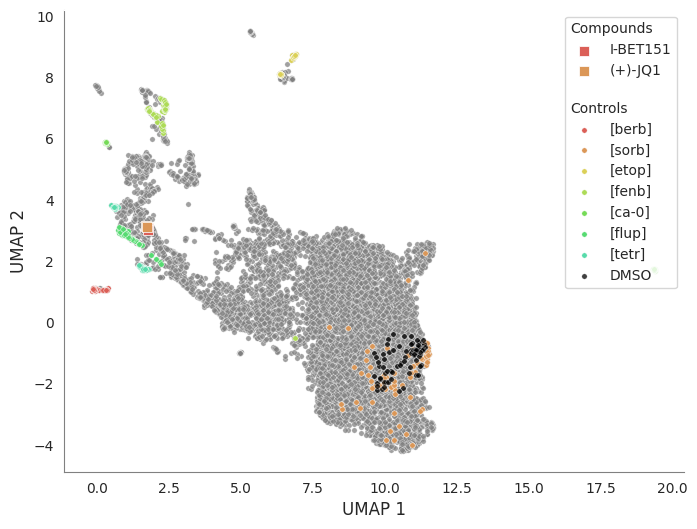

In [23]:
#Plot UMAP
c.umap_compounds(dfGroupedByPlate1, annotations, CompoundNames, ControlNames, random_state=90, file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/umap_IBET151_JQ1.svg')

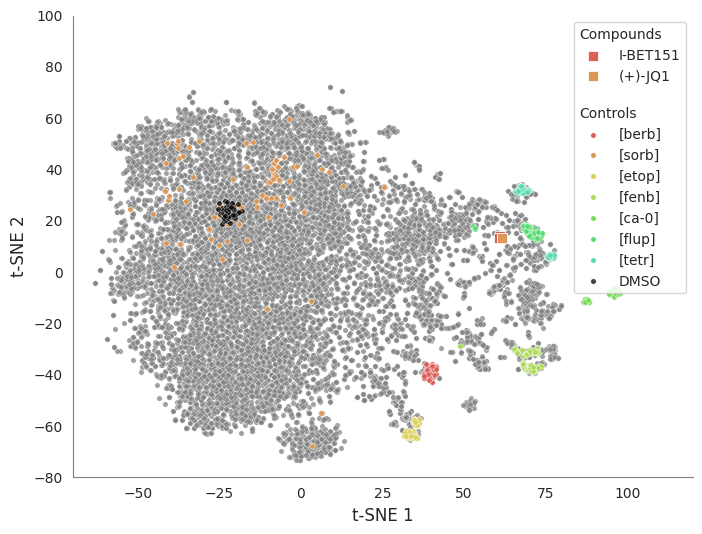

In [9]:
c.tsne_compounds(dfGroupedByPlate1, annotations, CompoundNames, ControlNames)

### Cluster CP data using SC3s and plot smallest clusters for each compound

In [ ]:
#Calculate consensus clustering
clusters_compounds = c.cluster_compound_sc3s(dfGroupedByPlate1, 
                                             CompoundNames, 
                                             batch_size = 1024,
                                             d_range = 50,
                                             n_runs = 500,
                                             file_name='/share/data/analyses/camilla/cp_tpp/processed_data/pca_specs_all_withClusters_2.parquet'
                                            )

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
INFO:root:multiplier_facility not set, using default value of 3...
INFO:root:number of facilities calculated as 540


Clustering with SC3s...


INFO:root:original binary matrix shape: (10941, 50000)
INFO:root:original binary matrix shape: (10941, 55000)
INFO:root:original binary matrix shape: (10941, 60000)


In [20]:
#Import previous concensus clustering
#Read in consensus clusters if the cell above has already been run
reload(c)

principalDf_conc = pd.read_parquet('/share/data/analyses/camilla/cp_tpp/processed_data/pca_specs_all_withClusters_2000runs1.parquet')
n_clusters = [100, 110, 120, 150, 180]

#Reset index
CompoundNames2 = {'I-BET151': 'CBK278083', '(+)-JQ1': 'CBK278065'
                }

principalDf_conc['cbkid'] = principalDf_conc['cbkid'].replace(CompoundNames2)
principalDf_conc.sort_values(by = ['cbkid'], inplace = True)
principalDf_conc.reset_index(inplace=True, drop=True)
principalDf_conc['cbkid'] = principalDf_conc['cbkid'].replace(CompoundNames)

#Find cluster for each compound
clusters_compounds = {i:[] for i in CompoundNames.values()}
for i in CompoundNames.values():
    clusters_compounds[i] = c.find_cluster(principalDf_conc, n_clusters, i)

For compound I-BET151
Cluster sc3s_100 is 86 long.
Cluster sc3s_110 is 41 long.
Cluster sc3s_120 is 43 long.
Cluster sc3s_150 is 43 long.
Cluster sc3s_180 is 71 long.
Smallest cluster sc3s_110 with length 41
For compound (+)-JQ1
Cluster sc3s_100 is 86 long.
Cluster sc3s_110 is 41 long.
Cluster sc3s_120 is 43 long.
Cluster sc3s_150 is 43 long.
Cluster sc3s_180 is 314 long.
Smallest cluster sc3s_110 with length 41


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


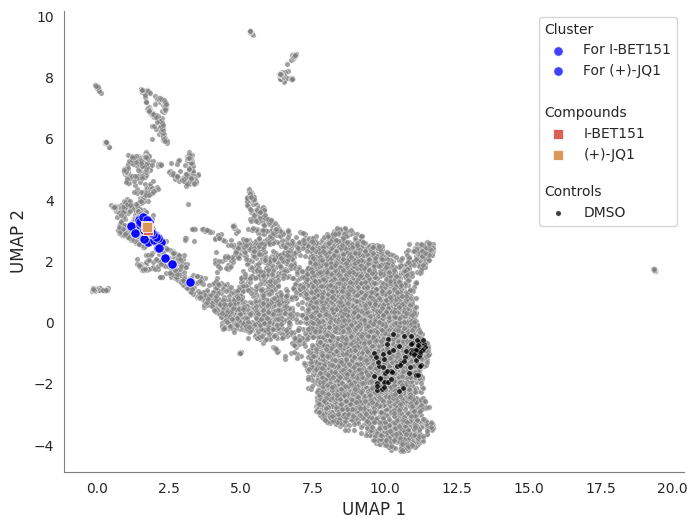

In [24]:
#Plot UMAP for identified clusters
c.umap_compounds(dfGroupedByPlate1, annotations, CompoundNames, ControlNames=None, random_state=90, Cluster=clusters_compounds, file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/umap_withClusters_IBET151_JQ1_v2000.svg')

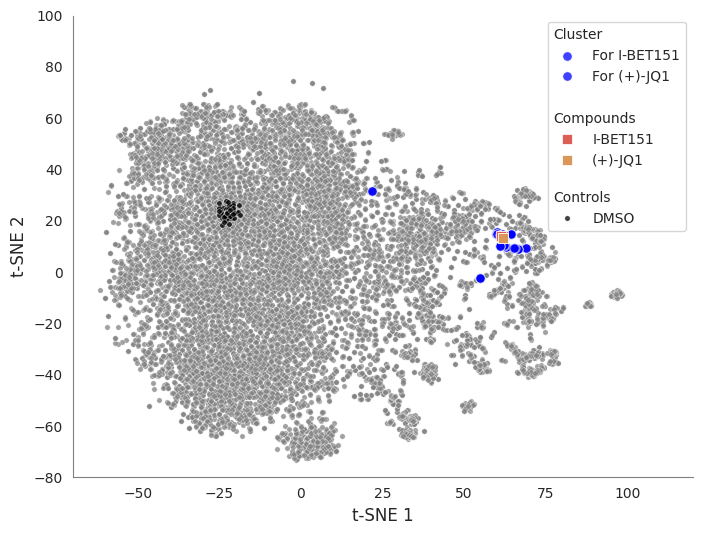

In [164]:
c.tsne_compounds(dfGroupedByPlate1, annotations, CompoundNames, ControlNames=None, Cluster=clusters_compounds, file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/tsne_withClusters_IBET151_JQ1_v2000.svg')

### Radar charts and feature similarity maps for compounds

In [22]:
#Read in processed data (if you have already run the previous step once)
dfGroupedByPlate1 =  pd.read_parquet('/share/data/analyses/camilla/cp_tpp/processed_data/median_processed_specs_all.parquet')

# Import annotations
annotations = pd.read_csv('/share/data/analyses/martin/024_specs_all/annotations.csv', sep=';', encoding='unicode_escape')

I-BET151
Radar Chart saved as:
/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/radar_chart_I-BET151.svg


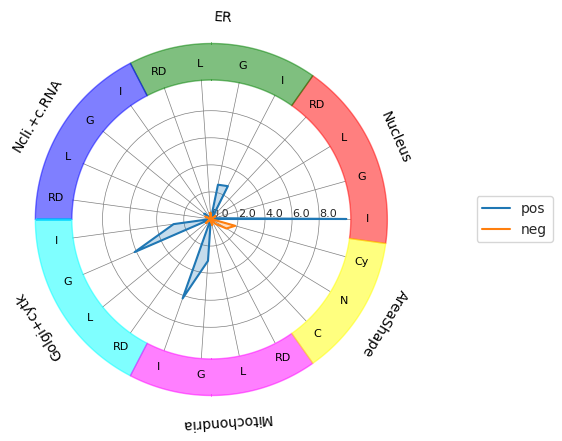

(+)-JQ1
Radar Chart saved as:
/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/radar_chart_(+)-JQ1.svg


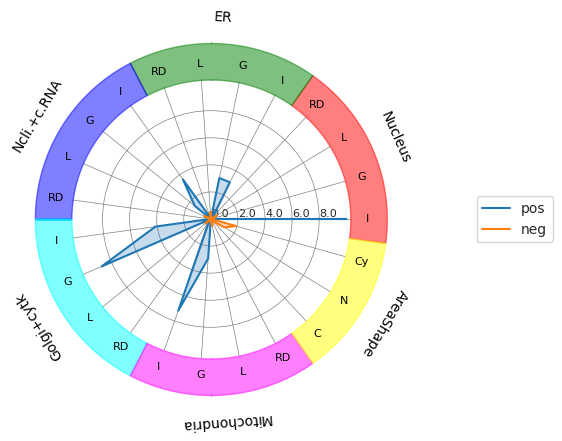

In [19]:
#Prepare data for plotting radar charts
dfRadar = c.processDataForRadar(dfGroupedByPlate1, CompoundNames)

#Plot radar charts
for compound in CompoundNames.values():
    print(compound)
    file_name = '/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/radar_chart_' + compound + '.svg'
    c.plotRadar(dfRadar, compound, file_name=file_name)

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


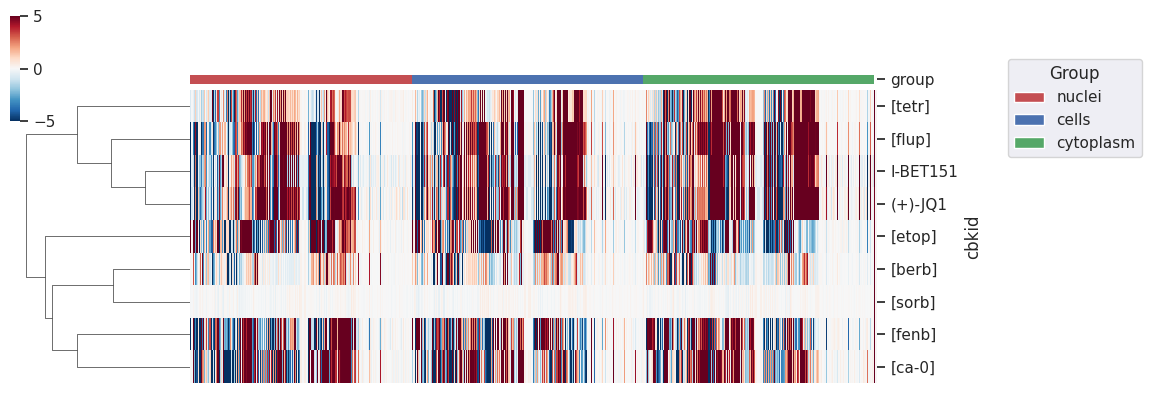

In [8]:
#Plot feature heatmap
c.plotFeatureHeatmap(dfGroupedByPlate1, CompoundNames, ControlNames, file_name=None)

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


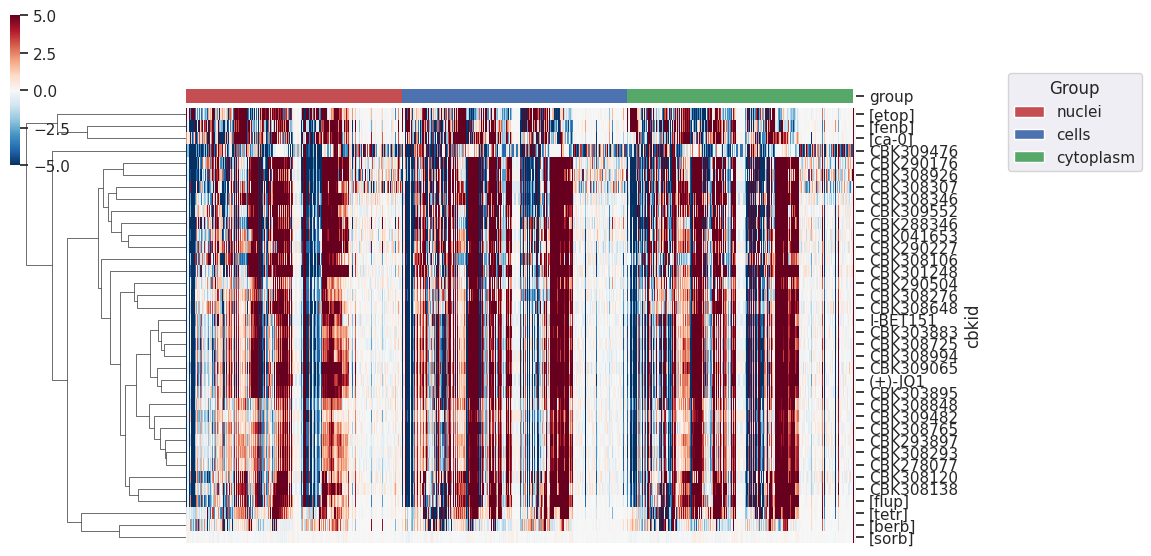

In [9]:
#Plot feature heatmap which includes compounds from SC3s clusters. 
c.plotFeatureHeatmap(dfGroupedByPlate1, CompoundNames, ControlNames, file_name=None, Cluster=clusters_compounds, height=5)

### Plot prevalence of compound targets in CP data
This was discussed on a meeting (2025-01-30). For the compounds we are interested in, how likely are they to map morphologically to other compounds targeting the same proteins? Since the approach in our model is built on the assumption that compounds will cluster closely to other compounds sharing similar targets, we need to also show to what extent this is true. 

In [161]:
reload(c)
#Extract targets for compounds of interest
targets_ibet151 = c.findTargetsForCompound(dfGroupedByPlate1, annotations, 'CBK278083')
targets_jq1 = c.findTargetsForCompound(dfGroupedByPlate1, annotations, 'CBK278065')
targets_jq1_ibet151 = targets_jq1 + targets_ibet151


In [162]:
#For all compounds in CP data, create a list of indices where compounds target any of these proteins. 
reload(c)
cluster_targets_jq1_ibet151 = c.findClusterForCompoundTargets(dfGroupedByPlate1, annotations, targets_jq1_ibet151)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


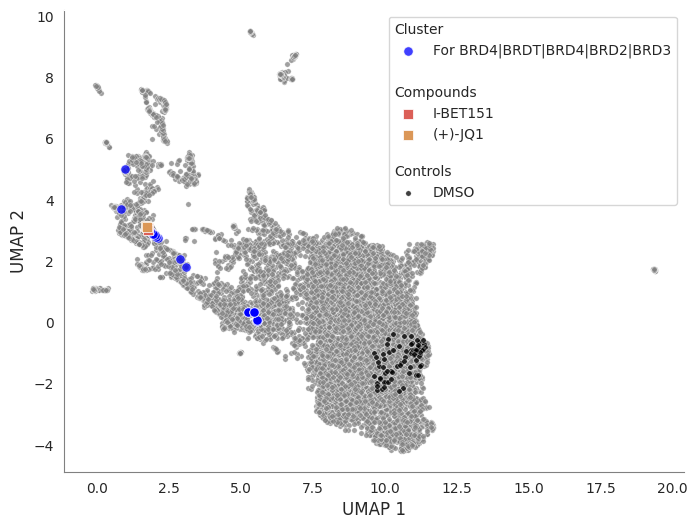

In [27]:
#Plot clusters in UMAP.
cluster_targets_jq1_ibet151_dict = {"|".join(targets_jq1_ibet151):cluster_targets_jq1_ibet151}

c.umap_compounds(dfGroupedByPlate1, 
                 annotations, 
                 CompoundNames, 
                 ControlNames=None,
                 random_state=90,
                 Cluster=cluster_targets_jq1_ibet151_dict, 
                 file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/umap_compoundsWithSharedTargets_IBET151_JQ1.svg'
                )

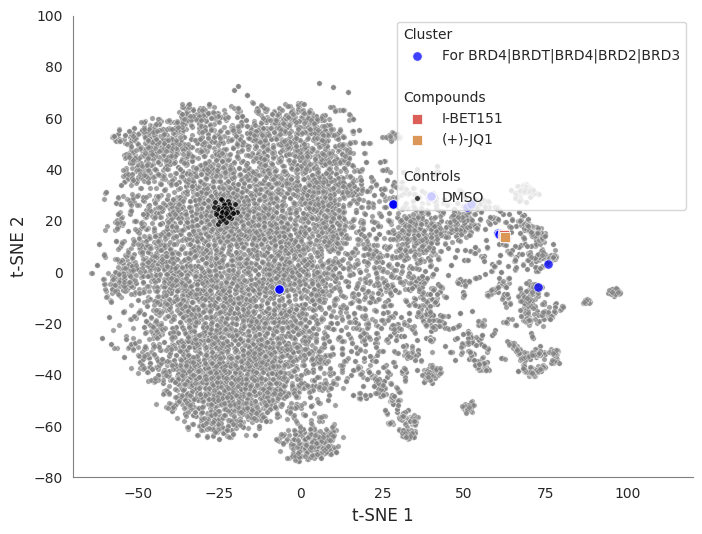

In [163]:
#Plot clusters in UMAP.
cluster_targets_jq1_ibet151_dict = {"|".join(targets_jq1_ibet151):cluster_targets_jq1_ibet151}

c.tsne_compounds(dfGroupedByPlate1, 
                 annotations, 
                 CompoundNames, 
                 ControlNames=None,
                 #random_state=90,
                 Cluster=cluster_targets_jq1_ibet151_dict, 
                 file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/tsne_compoundsWithSharedTargets_IBET151_JQ1_2000rep.svg'
                )

**Repeat for Roscovitine**

In [35]:
reload(c)
#Extract targets for compounds of interest
targets_rosc = c.findTargetsForCompound(dfGroupedByPlate1, annotations, 'CBK278001')


In [36]:
#For all compounds in CP data, create a list of indices where compounds target any of these proteins. 
reload(c)
cluster_targets_rosc = c.findClusterForCompoundTargets(dfGroupedByPlate1, annotations, targets_rosc)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


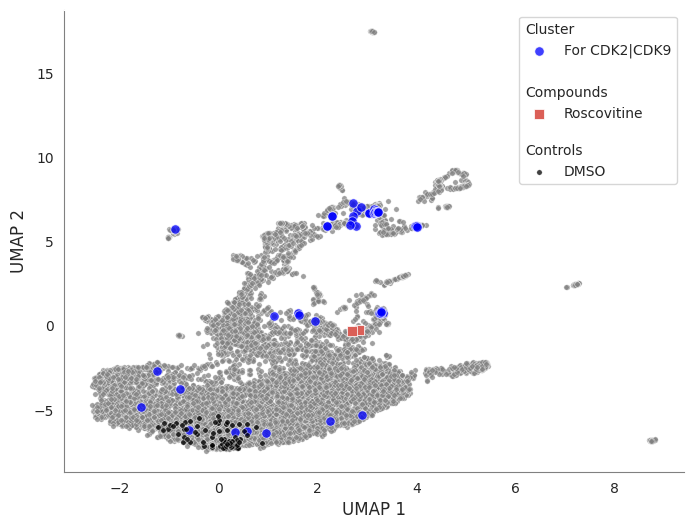

In [38]:
#Plot clusters in UMAP.
CompoundNames_rosc = {'CBK278001': 'Roscovitine'
                }

cluster_targets_rosc_dict = {"|".join(targets_rosc):cluster_targets_rosc}

c.umap_compounds(dfGroupedByPlate1, 
                 annotations, 
                 CompoundNames_rosc, 
                 ControlNames=None, 
                 Cluster=cluster_targets_rosc_dict, 
                 file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/umap_compoundsWithSharedTargets_Roscovitine.tiff'
                )

**Repeat for Vemurafenib**

In [65]:
reload(c)
#Extract targets for compounds of interest
targets_vem = c.findTargetsForCompound(dfGroupedByPlate1, annotations, 'CBK277976')


In [66]:
#For all compounds in CP data, create a list of indices where compounds target any of these proteins. 
reload(c)
cluster_targets_vem = c.findClusterForCompoundTargets(dfGroupedByPlate1, annotations, targets_vem)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


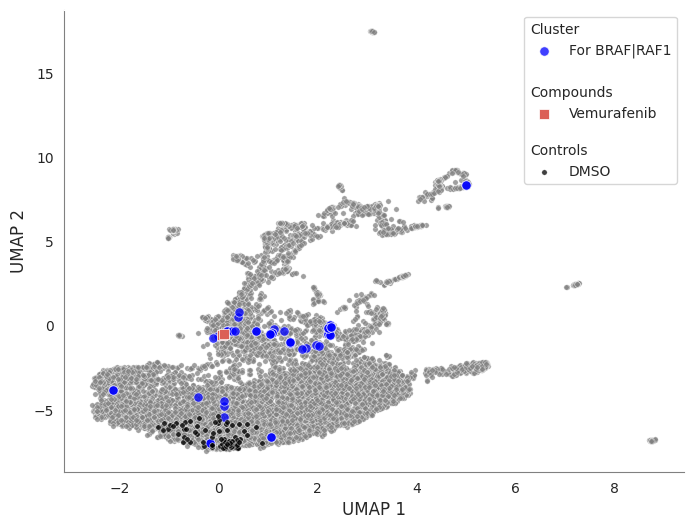

In [67]:
#Plot clusters in UMAP.
CompoundNames_vem = {'CBK277976': 'Vemurafenib'
                }

cluster_targets_vem_dict = {"|".join(targets_vem):cluster_targets_vem}

c.umap_compounds(dfGroupedByPlate1, 
                 annotations, 
                 CompoundNames_vem, 
                 ControlNames=None, 
                 Cluster=cluster_targets_vem_dict, 
                 file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/umap_compoundsWithSharedTargets_Vemurafenib.tiff'
                )

**Repeat for Crizotinib**

In [63]:
reload(c)
#Extract targets for compounds of interest
targets_cri = c.findTargetsForCompound(dfGroupedByPlate1, annotations, 'CBK277930')

#For all compounds in CP data, create a list of indices where compounds target any of these proteins. 
cluster_targets_cri = c.findClusterForCompoundTargets(dfGroupedByPlate1, annotations, targets_cri)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


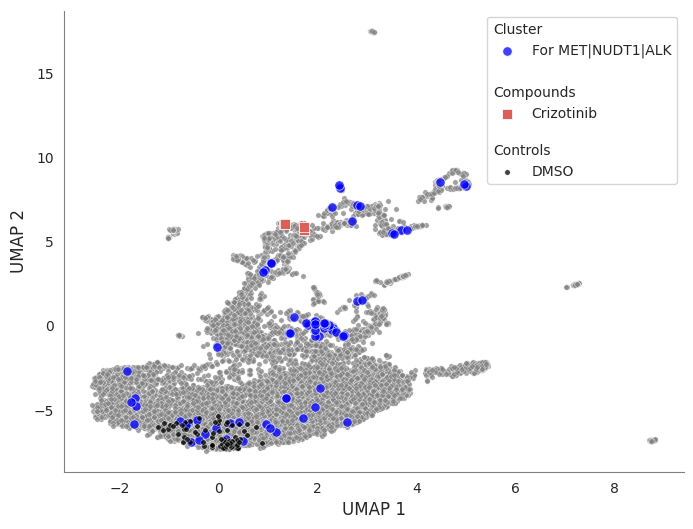

In [64]:
#Plot clusters in UMAP.
CompoundNames_cri = {'CBK277930': 'Crizotinib'
                }

cluster_targets_cri_dict = {"|".join(targets_cri):cluster_targets_cri}

c.umap_compounds(dfGroupedByPlate1, 
                 annotations, 
                 CompoundNames_cri, 
                 ControlNames=None, 
                 Cluster=cluster_targets_cri_dict, 
                 file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/umap_compoundsWithSharedTargets_Crizotinib.tiff'
                )

**Repeat for Panobinostat**

In [44]:
reload(c)
#Extract targets for compounds of interest
targets_pan = c.findTargetsForCompound(dfGroupedByPlate1, annotations, 'CBK277990')

#For all compounds in CP data, create a list of indices where compounds target any of these proteins. 
cluster_targets_pan = c.findClusterForCompoundTargets(dfGroupedByPlate1, annotations, targets_pan)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


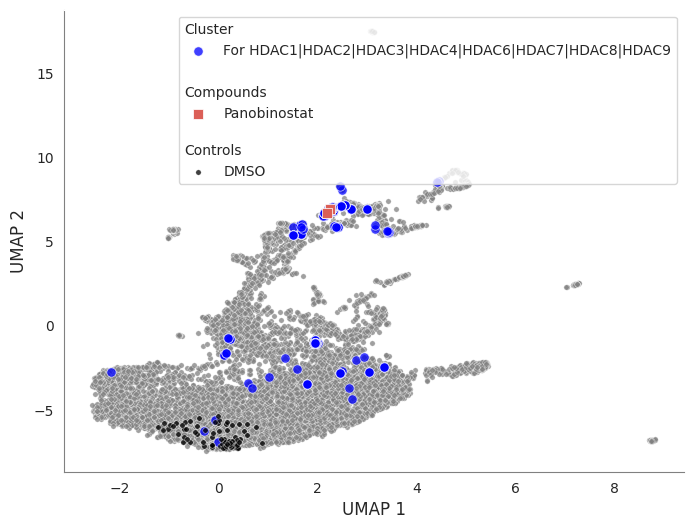

In [45]:
#Plot clusters in UMAP.
CompoundNames_pan = {'CBK277990': 'Panobinostat'
                }

cluster_targets_pan_dict = {"|".join(targets_pan):cluster_targets_pan}

c.umap_compounds(dfGroupedByPlate1, 
                 annotations, 
                 CompoundNames_pan, 
                 ControlNames=None, 
                 Cluster=cluster_targets_pan_dict, 
                 file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/umap_compoundsWithSharedTargets_Panobinostat.tiff'
                )

**Repeat for Elacridar**

In [ ]:
reload(c)
#Extract targets for compounds of interest
targets_elac = c.findTargetsForCompound(dfGroupedByPlate1, annotations, 'CBK291007')

#For all compounds in CP data, create a list of indices where compounds target any of these proteins. 
cluster_targets_elac = c.findClusterForCompoundTargets(dfGroupedByPlate1, annotations, targets_elac)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


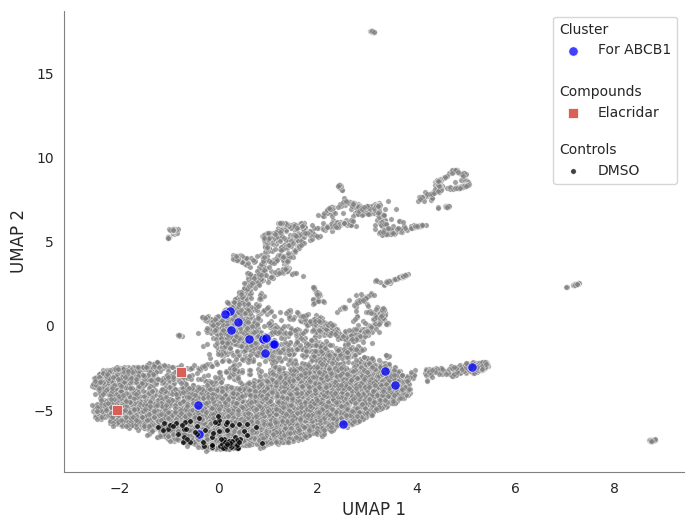

In [ ]:
#Plot clusters in UMAP.
CompoundNames_elac = {'CBK291007': 'Elacridar'
                }

cluster_targets_elac_dict = {"|".join(targets_elac):cluster_targets_elac}

c.umap_compounds(dfGroupedByPlate1, 
                 annotations, 
                 CompoundNames_elac, 
                 ControlNames=None, 
                 Cluster=cluster_targets_elac_dict, 
                 file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/umap_compoundsWithSharedTargets_Elacridar.tiff'
                )

## Thermal proteome profiling data

Thermal Proteome Profiling (TPP) should first be processed in R using the TPP library. https://www.bioconductor.org/packages/release/bioc/html/TPP.html 

Depending on the type of TPP experiment, different pre-processing functions are used, and this affects the appearance of the results table generated by the R function. Use the following functions from the TPP package depending on your data type: 

* TPP-TR: function "analyzeTPPTR". https://www.bioconductor.org/packages/release/bioc/vignettes/TPP/inst/doc/TPP_introduction_1D.pdf
* 2D-TPP: function "analyze2DTPP". https://www.bioconductor.org/packages/release/bioc/vignettes/TPP/inst/doc/TPP_introduction_2D.pdf

In both cases, data is assumed to contain TMT labels and you will need to create a "configTable" and "data" file with a few very specific columns for the functions to work. This is all very well described in the documentation linked above. 

The results generated with these functions include an excel file with all processed and normalised intensities and statistical test results. We will use these result files as input to this python model. 

### Extract significantly affected proteins from TPP data

In [464]:
#Run this code if you have TPP-TR data. 
reload(tpp)

proteins_all_rosc, proteins_stab_rosc, proteins_destab_rosc = tpp.extractSignifTargetsTPPTR("/share/data/analyses/camilla/cp_tpp/figures/results_TPP_TR.xlsx", sheet_name=0, header=0)
#tpp.extractSignifTargetsTPPTR("/share/data/analyses/camilla/cp_tpp/figures/results_TPP_TR.xlsx", sheet_name=0, header=0, max_fdr=1)

In [28]:
#Run this code if you have 2D-TPP data.
reload(tpp)
proteins_all_jq1, proteins_stab_jq1, proteins_destab_jq1 = tpp.extractSignifTargets2DTPP("/share/data/analyses/camilla/cp_tpp/processed_data/Supplementary Dataset 2_2D-TPP.xlsx")

proteins_all_jq1_ce, proteins_stab_jq1_ce, proteins_destab_jq1_ce = tpp.extractSignifTargets2DTPP("/share/data/analyses/camilla/cp_tpp/processed_data/Supplementary Dataset 2_2D-TPP.xlsx", sheet_name=2)

proteins_all_ibet151, proteins_stab_ibet151, proteins_destab_ibet151 = tpp.extractSignifTargets2DTPP("/share/data/analyses/camilla/cp_tpp/processed_data/Supplementary Dataset 2_2D-TPP.xlsx", sheet_name=3)

In [29]:
print('Number of proteins identified in JQ1 treated whole cells: '+str(len(proteins_all_jq1)))
print('Number of proteins identified in JQ1 treated cell extract: '+str(len(proteins_all_jq1_ce)))
print('Number of proteins identified in I-BET151 treated whole cells: '+str(len(proteins_all_ibet151)))

Number of proteins identified in JQ1 treated whole cells: 64
Number of proteins identified in JQ1 treated cell extract: 12
Number of proteins identified in I-BET151 treated whole cells: 40


In [30]:
#Create LaTeX table of significant proteins for manuscript
reload(tpp)
tpp.createTargetTable_2DTPP("/share/data/analyses/camilla/cp_tpp/processed_data/Supplementary Dataset 2_2D-TPP.xlsx", 
                                 cutoff=2, sheet_name = 1, header=1,
                                 passed_filter_columns=['passed_filter'],
                                 save_latex_table=True,
                                 save_path="/share/data/analyses/camilla/cp_tpp/tables/",
                                 file_name="signifProteins_TPP_JQ1_latexTable.txt")

tpp.createTargetTable_2DTPP("/share/data/analyses/camilla/cp_tpp/processed_data/Supplementary Dataset 2_2D-TPP.xlsx", 
                                 cutoff=2, sheet_name = 2, header=1,
                                 passed_filter_columns=['passed_filter'],
                                 save_latex_table=True,
                                 save_path="/share/data/analyses/camilla/cp_tpp/tables/",
                                 file_name="signifProteins_TPP_JQ1_cellExtract_latexTable.txt")

tpp.createTargetTable_2DTPP("/share/data/analyses/camilla/cp_tpp/processed_data/Supplementary Dataset 2_2D-TPP.xlsx", 
                                 cutoff=2, sheet_name = 3, header=1,
                                 passed_filter_columns=['passed_filter'],
                                 save_latex_table=True,
                                 save_path="/share/data/analyses/camilla/cp_tpp/tables/",
                                 file_name="signifProteins_TPP_IBET151_latexTable.txt")

In [31]:
#Import external subcellular location data from Human Protein Atlas
feature_df = pd.read_csv("/share/data/analyses/camilla/cp_tpp/raw_data/subcellular_location.tsv", sep="\t")

#Import external cell line expression data from Human Protein Atlas
exp_df = pd.read_csv("/share/data/analyses/camilla/cp_tpp/raw_data/rna_celline.tsv", sep="\t")
exp_df = exp_df[exp_df["Cell line"] == "U2OS"]

#Define location of external data files needed for plotting. 
external_data = {"subcellular": ["/share/data/analyses/camilla/cp_tpp/raw_data/subcellular_location.tsv"],
                 "cell line": ["/share/data/analyses/camilla/cp_tpp/raw_data/rna_celline.tsv"],
                 "num temp curves": ["/share/data/analyses/camilla/cp_tpp/processed_data/Supplementary Dataset 2_2D-TPP.xlsx", 
                                     {"sheet_name":1, "header":1}],
                 "direction": ["/share/data/analyses/camilla/cp_tpp/processed_data/Supplementary Dataset 2_2D-TPP.xlsx", 
                                     {"sheet_name":1, "header":1}],
                 "other TPP data": ["/share/data/analyses/camilla/cp_tpp/processed_data/Supplementary Dataset 2_2D-TPP.xlsx", 
                                     {"sheet_name":2, "header":1}, {"cutoff": 2}]
                }

### Plot subcellular extression histogram

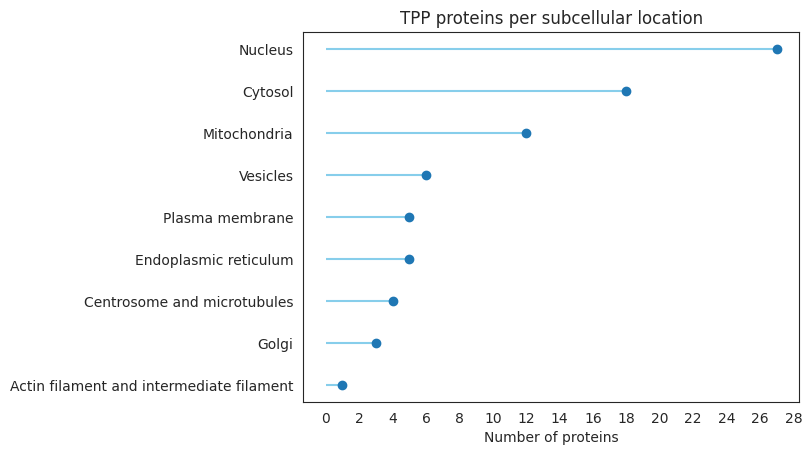

In [32]:
reload(tpp)
tpp.make_sl_histogram(proteins_all_jq1, feature_df, 
                      file_name="/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/histogram_subcellular_jq1_wc.svg")

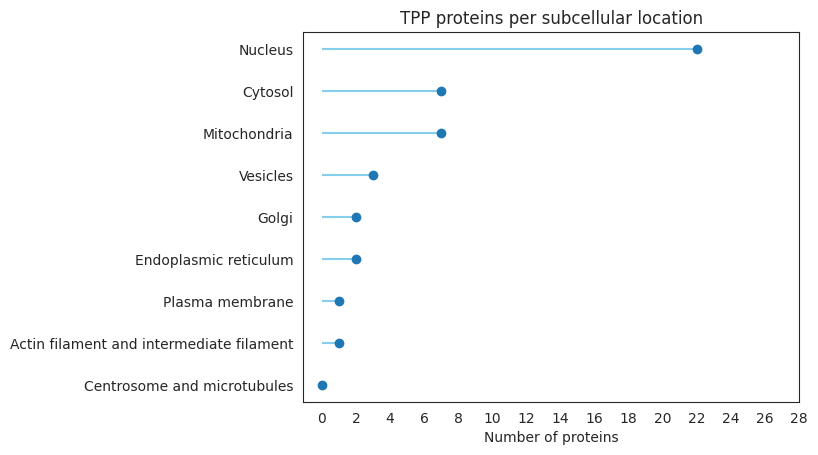

In [33]:
tpp.make_sl_histogram(proteins_all_ibet151, feature_df, 
                      file_name="/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/histogram_subcellular_ibet151_wc.svg")

### JQ1
#### Plot networks

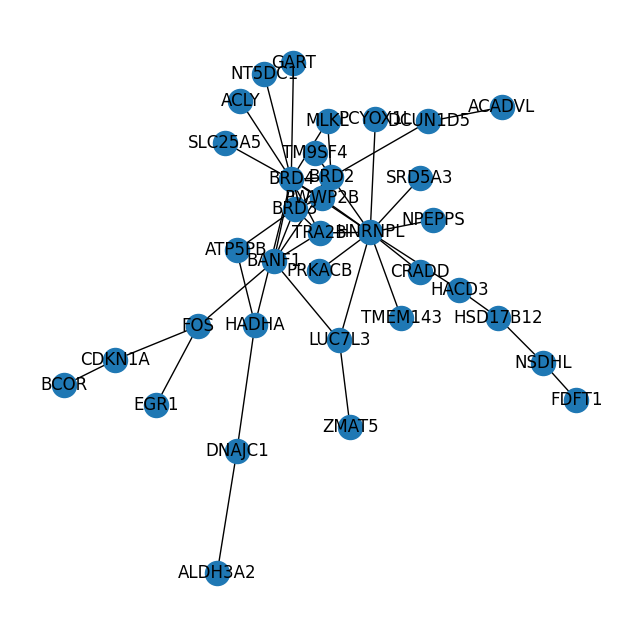

In [171]:
#Plot preliminary network
reload(tpp)
G_prel, interactions = tpp.retrievePreliminaryNetwork(proteins_all_jq1, network_type="physical")

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin' will be ignored
  node_collection = ax.scatter(


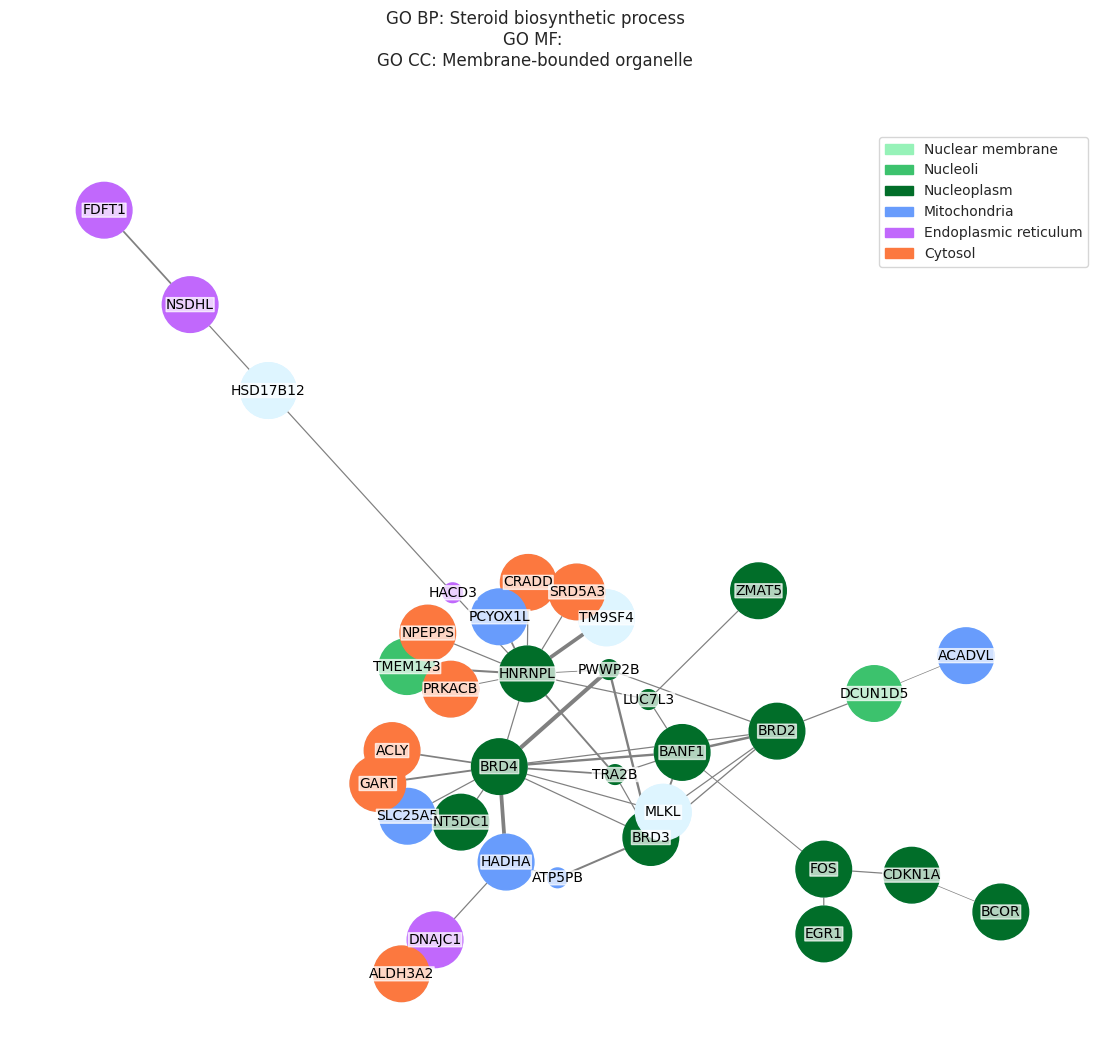

In [172]:
#Plot physical network 
#TODO: Additional legend with node size and edge thickness. 
random.seed(111)
np.random.seed(111)
reload(tpp)
between_c = tpp.plotPPINetwork(G_prel, 
                             interactions, 
                             community=1, #Number of separate (not connected) networks seen in preliminary network figure above.
                             protein_list=proteins_all_jq1,
                             external_data=external_data,
                             file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/ppi_network_jq1_subcellular_wc_physical_v2000.svg',
                             label_method="subcellular",
                             celline = "THP-1",
                             figure_size=(14,12)
                )

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin' will be ignored
  node_collection = ax.scatter(


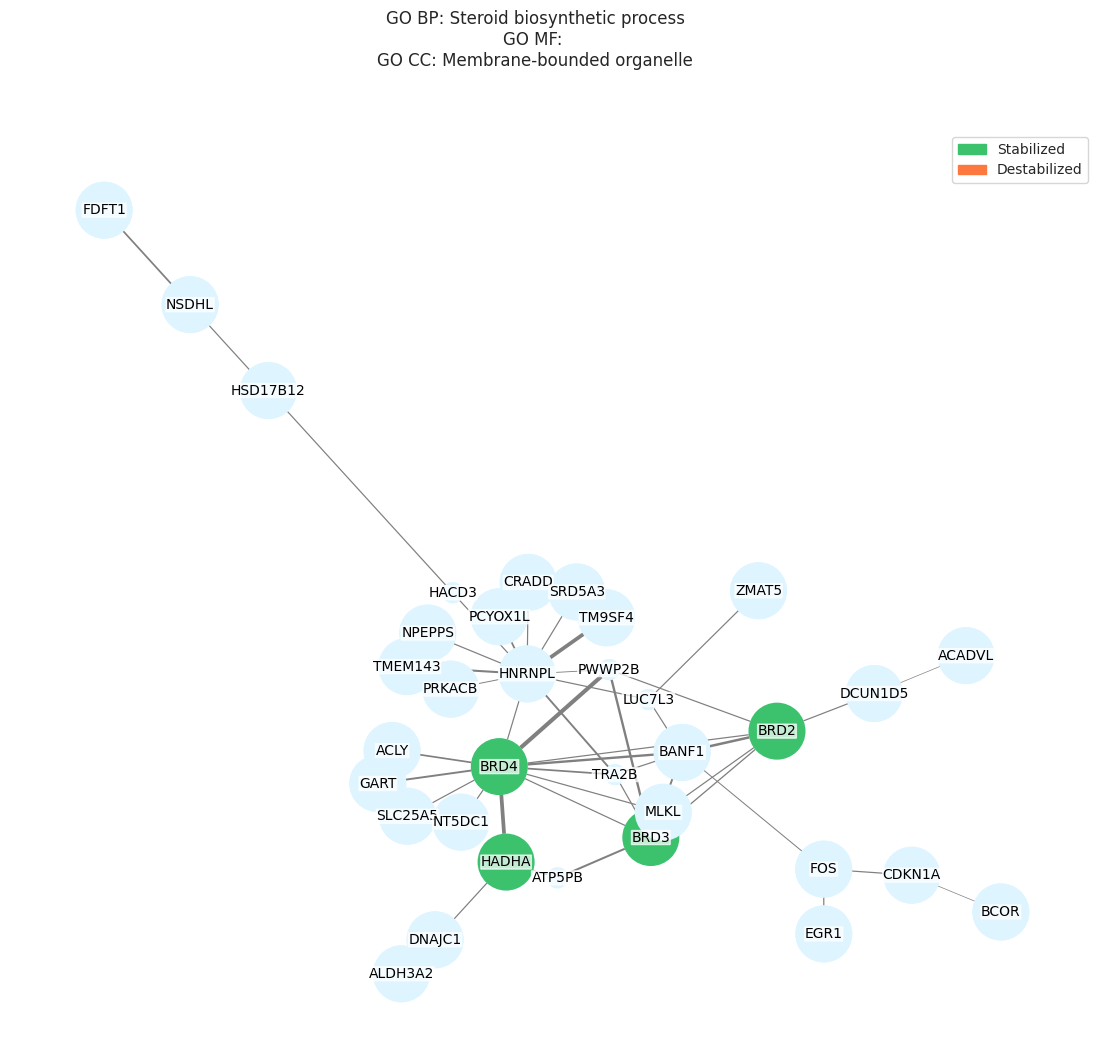

In [173]:
reload(tpp)
between_c = tpp.plotPPINetwork(G_prel, 
                             interactions, 
                             community=1, #Number of separate (not connected) networks seen in preliminary network figure above.
                             protein_list=proteins_all_jq1,
                             external_data=external_data,
                             file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/ppi_network_jq1_colByJQ1ce_wc_physical_v2000.svg',
                             label_method="other TPP data",
                             celline = "THP-1",
                             figure_size=(14,12)
                )

In [174]:
reload(c)
#Summarize betweenness centrality for network. 
between_df = tpp.findLargestBetweennessCentrality(between_c, proteins_all_jq1, removeList=False, output_size=10)
print(between_df)

                 0
HNRNPL    0.559715
BRD4      0.484848
BANF1     0.251931
FOS       0.169340
HACD3     0.165775
BRD2      0.125074
HADHA     0.124480
HSD17B12  0.114082
LUC7L3    0.094474
DNAJC1    0.058824


In [175]:
#Import proteins from cluster
compound = ['(+)-JQ1', 'I-BET151']
cluster_compound_jq1 = clusters_compounds[compound[0]]

cluster_targets_jq1 = tpp.findClusterProteins(dfGroupedByPlate1, annotations, cluster_highlight=cluster_compound_jq1, compound=compound, CompoundNames=CompoundNames)

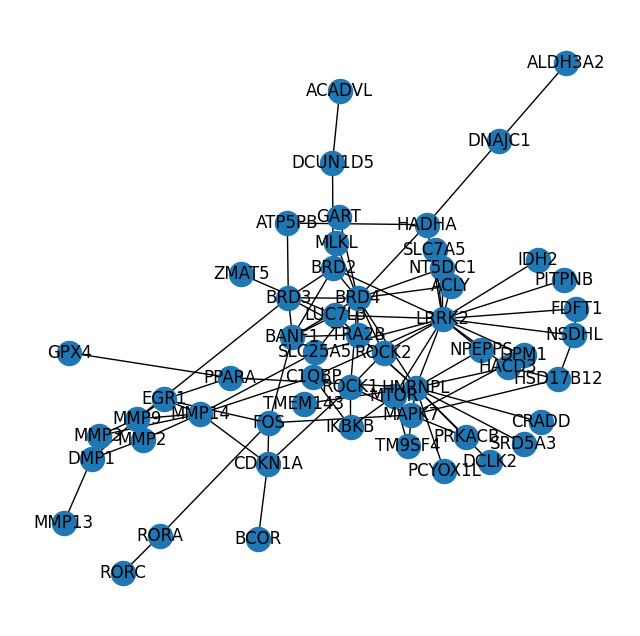

In [176]:
reload(c)
#Generate new network from string-db.
proteins_withCluster_jq1 = list(set(proteins_all_jq1+cluster_targets_jq1))

G_prel_clust, interactions_clust = tpp.retrievePreliminaryNetwork(proteins_withCluster_jq1, network_type="physical") 

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin' will be ignored
  node_collection = ax.scatter(


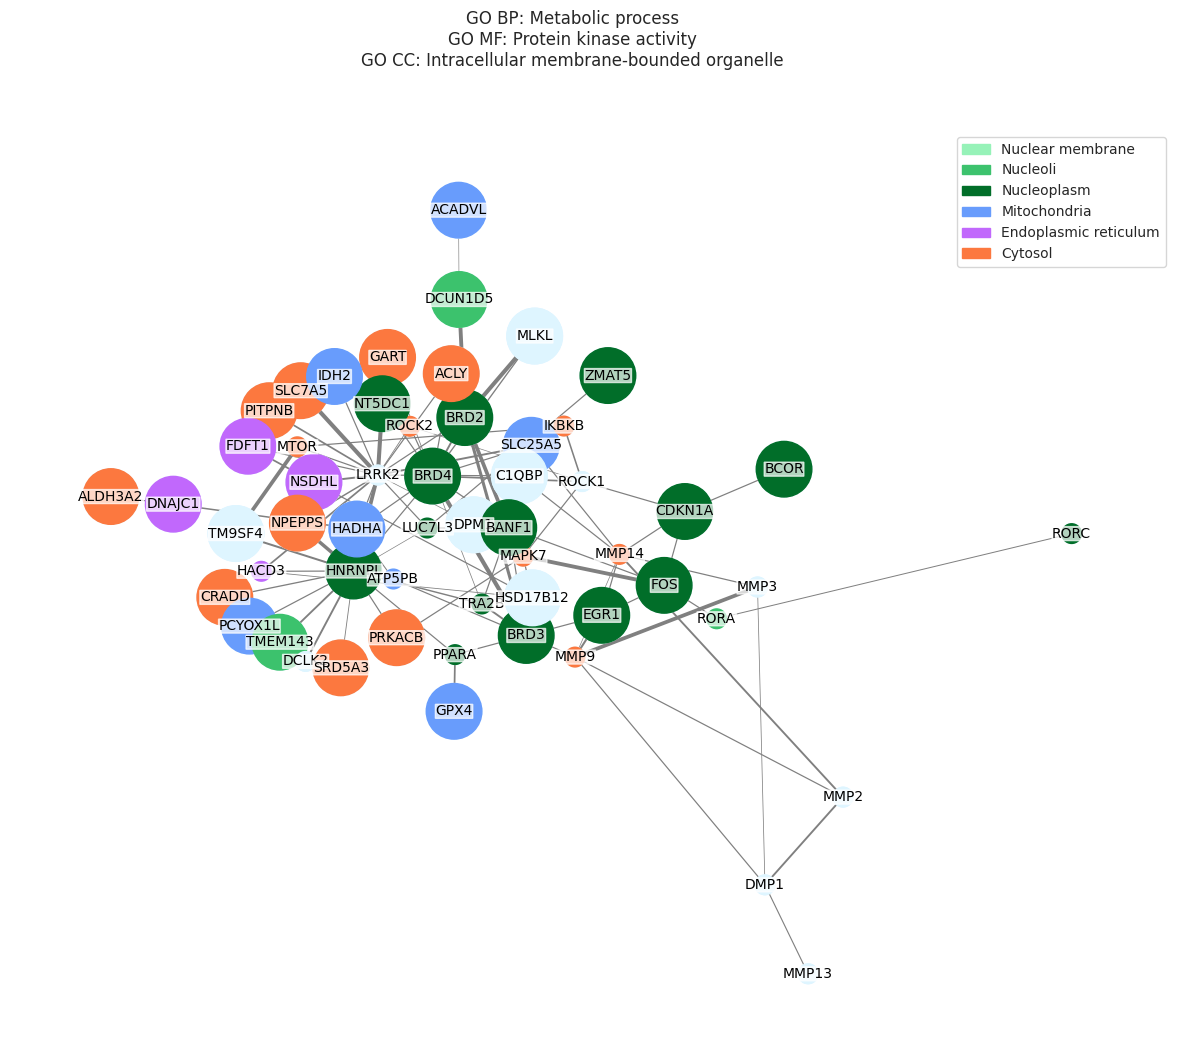

               0
LRRK2   0.367075
MMP14   0.095086
MMP9    0.087137
ROCK1   0.060109
PPARA   0.059511
LUC7L3  0.048833


In [177]:
#Plot new network from string-db.
reload(c)
between_c_clust = tpp.plotPPINetwork(G_prel_clust, 
                             interactions_clust, 
                             community=1, #Number of separate (not connected) networks seen in preliminary network figure above.
                             protein_list=proteins_all_jq1,
                             external_data=external_data,
                             #file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/ppi_network_jq1_subcellular.svg',
                             label_method="subcellular",
                             #celline = "THP-1",
                             figure_size=(15,12)
                )
#Calculate betweenness centrality and keep only 5 best "additional" nodes. 
between_clust_df = tpp.findClusterProteinsToKeepInNetwork(between_c_clust, proteins_all_jq1, interactions_clust)
print(between_clust_df)

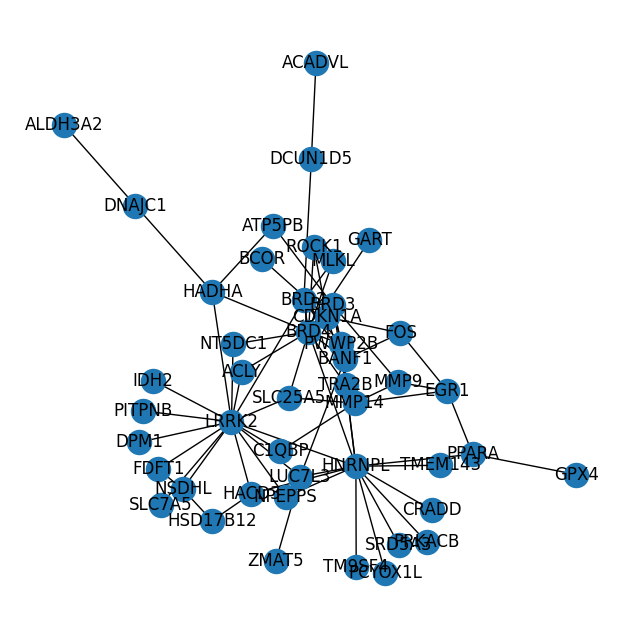

In [178]:
#Generate network with only best nodes
proteins_reducedCluster_jq1 = list(set(proteins_all_jq1+list(between_clust_df.index)))

G_prel_clust, interactions_clust = tpp.retrievePreliminaryNetwork(proteins_reducedCluster_jq1, network_type="physical") 

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin' will be ignored
  node_collection = ax.scatter(


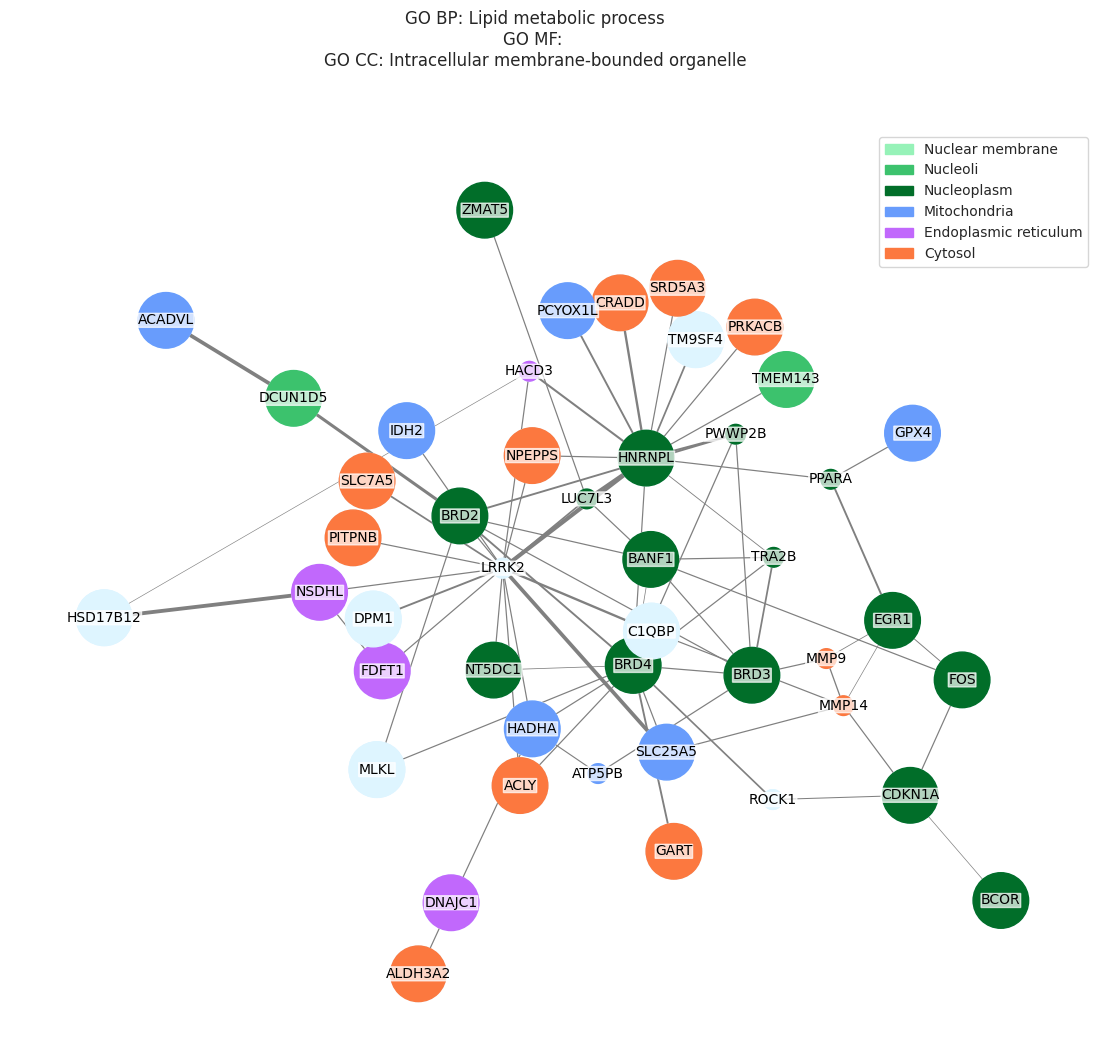

               0
LRRK2   0.408847
HNRNPL  0.372167
BRD4    0.250350
BRD2    0.129570
HADHA   0.110693
PPARA   0.066918
BANF1   0.060221
LUC7L3  0.058943
BRD3    0.055685
MMP14   0.052531


In [179]:
#Plot final network.
reload(tpp)
between_c_clust = tpp.plotPPINetwork(G_prel_clust, 
                             interactions_clust, 
                             community=1, #Number of separate (not connected) networks seen in preliminary network figure above.
                             protein_list=proteins_all_jq1,
                             external_data=external_data,
                             file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/ppi_network_jq1_subcellular_wc_physical_wCluster_v2.svg',
                             label_method="subcellular",
                             celline = "THP-1",
                             figure_size=(14,12)
                )
#Calculate betweenness centrality and keep only 5 best "additional" nodes. 
between_clust_df = tpp.findLargestBetweennessCentrality(between_c_clust, proteins_all_jq1, removeList=False, output_size=10)
print(between_clust_df)

/share/data/analyses/camilla/cp_tpp/code/cp_tpp_model/tpp/tpp.py:921: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  


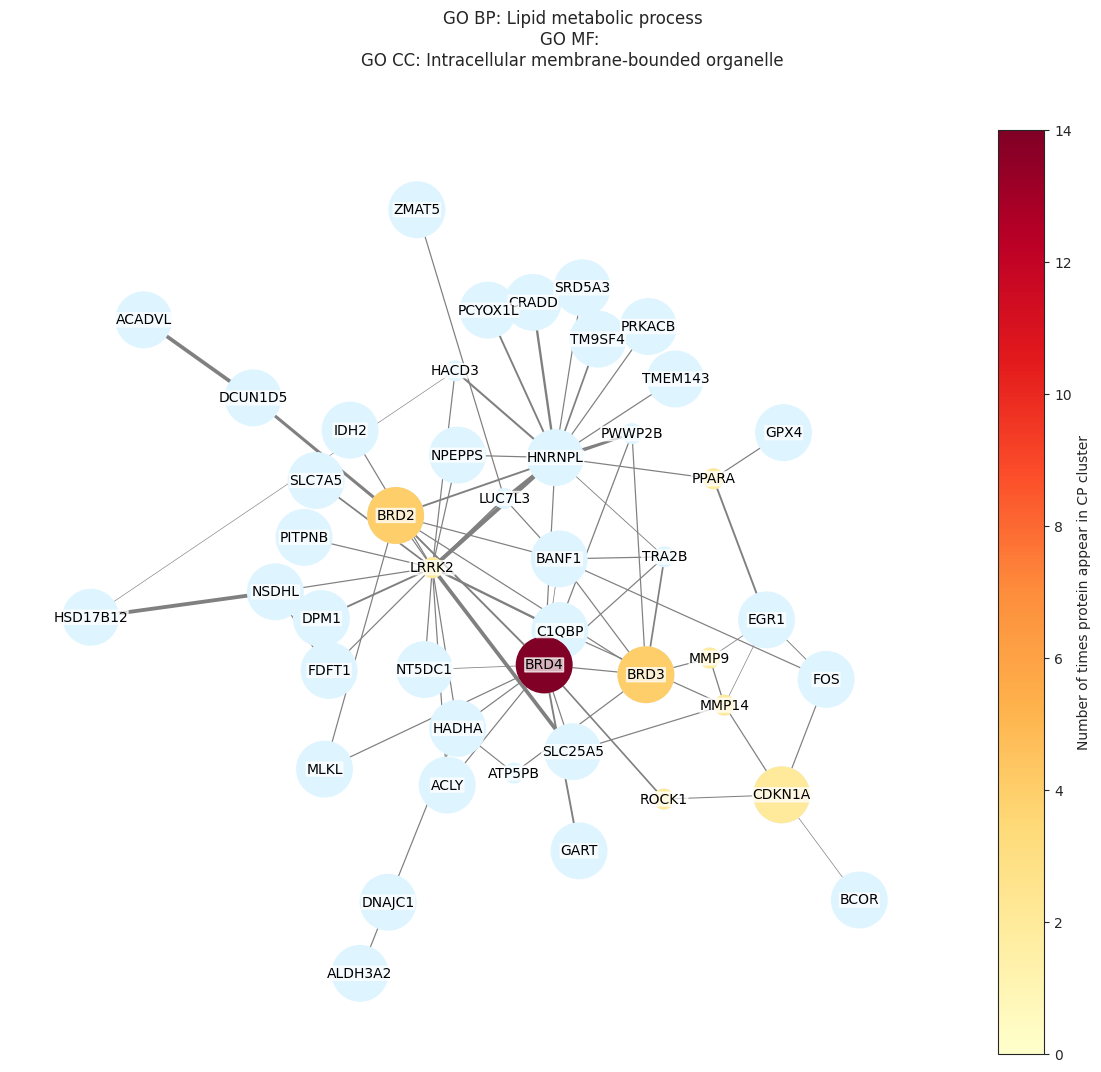

In [180]:
#Plot network colored by how many times a protein is present in cluster from cell painting data
reload(tpp)
cluster_protein_counts = tpp.countClusterProteins(dfGroupedByPlate1, annotations, cluster_highlight=cluster_compound_jq1, compound=compound, CompoundNames=CompoundNames)

between_c_clust = tpp.plotPPINetwork(G_prel_clust, 
                             interactions_clust, 
                             community=1, #Number of separate (not connected) networks seen in preliminary network figure above.
                             protein_list=proteins_all_jq1,
                             external_data=external_data,
                             file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/ppi_network_jq1_clusterCount_wc_physical_wCluster_v2.svg',
                             label_method="cluster count",
                             celline = "THP-1",
                             cluster_count_df = cluster_protein_counts,
                             figure_size=(15,12)
                )

#### Communitites and GO/Reactome enrichment

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin' will be ignored
  node_collection = ax.scatter(


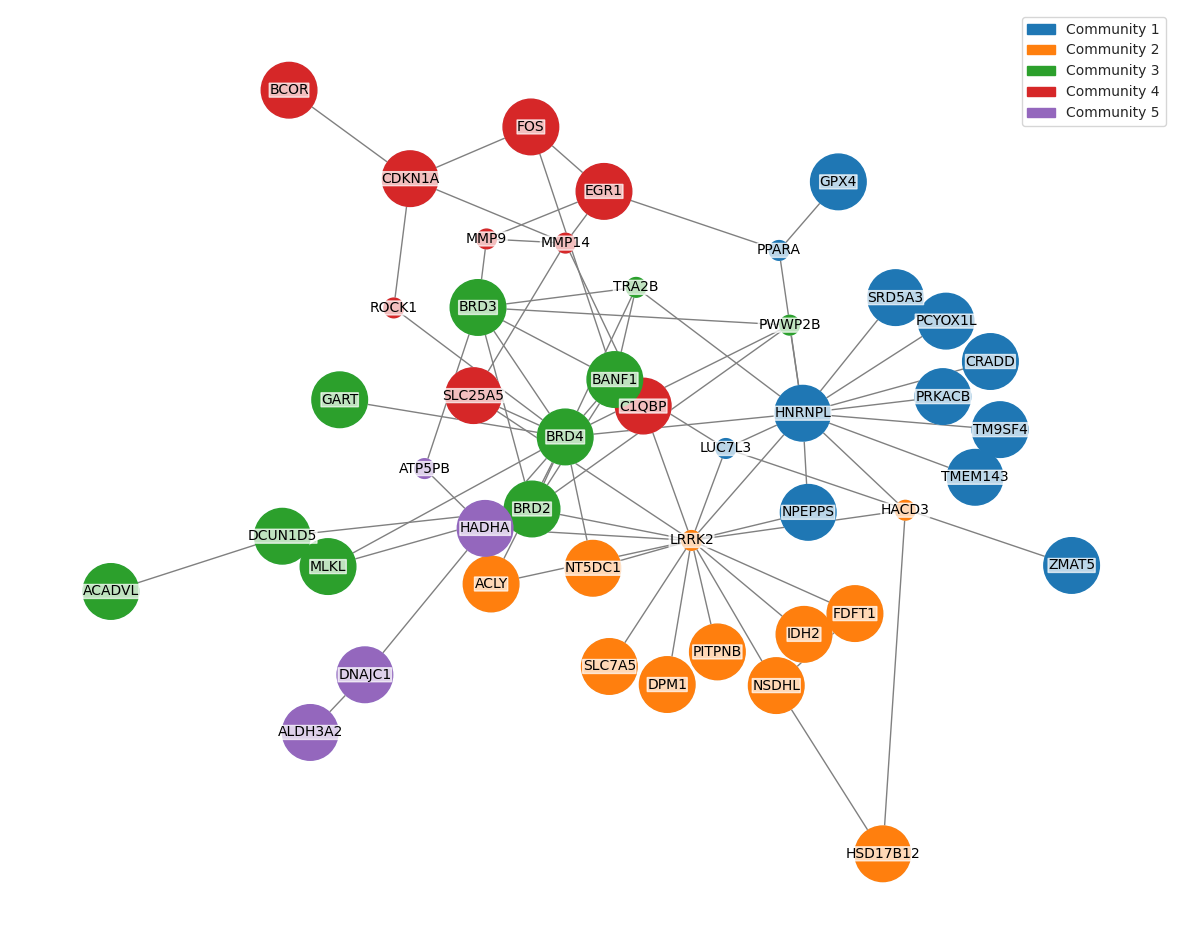

In [181]:
#Plot PPI network graph with communities as colors 
reload(tpp)
enrichment = tpp.plotPPINetworkCommunitites(G_prel_clust, 
                             interactions_clust, 
                             community=8, #Number of communities to subdivide graph into.
                             protein_list=proteins_all_jq1,
                             method = 'greedy_modularity_communities', # Method for identifying communitites. 
                             file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/ppi_network_jq1_communities_wc_physical_wCluster_2000rep.svg',
                             figure_size=(15,12)
                )

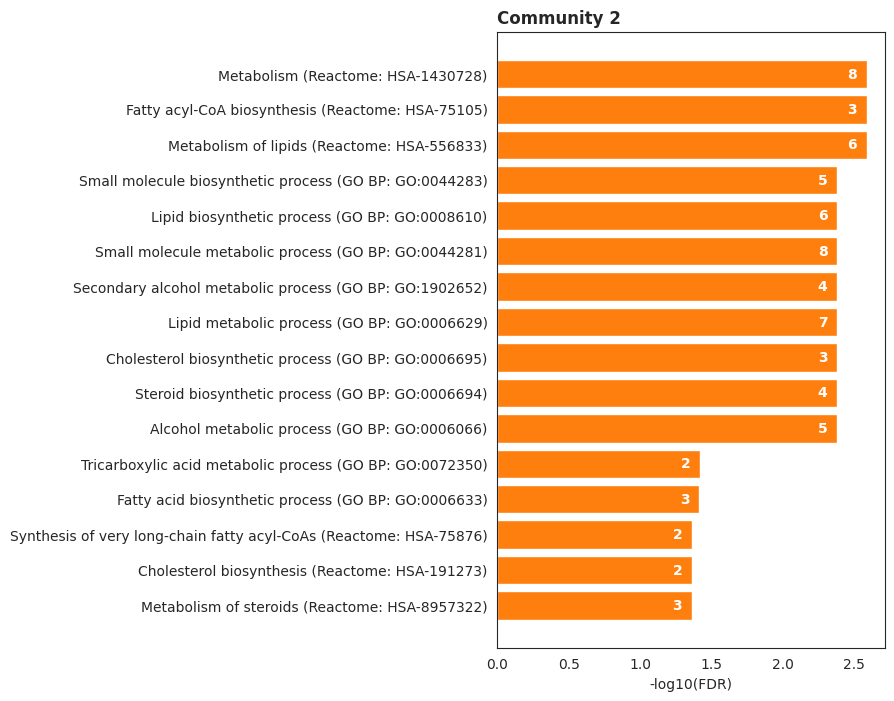

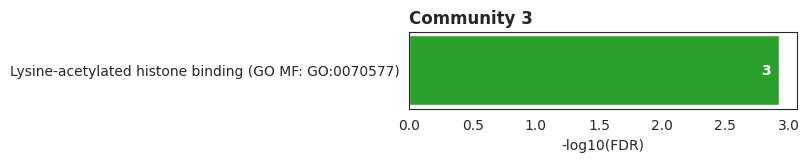

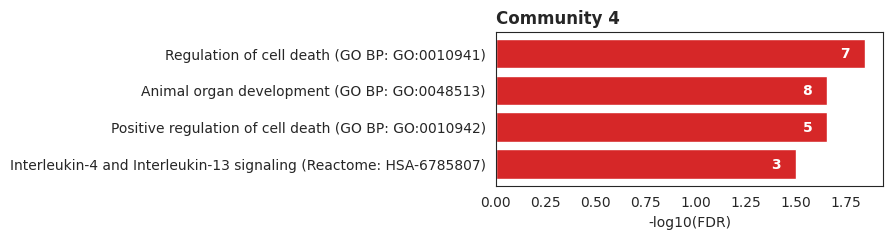

In [182]:
# Plots GO enrichment analysis for communitites. 
reload(tpp)
tpp.plotGOenrichmentCommunities(enrichment, 
                            file_name = "/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/enrichment_plots_jq1_communities_wc_physical_wCluster_2000rep.svg"
                           )

#### Network on cluster compounds only

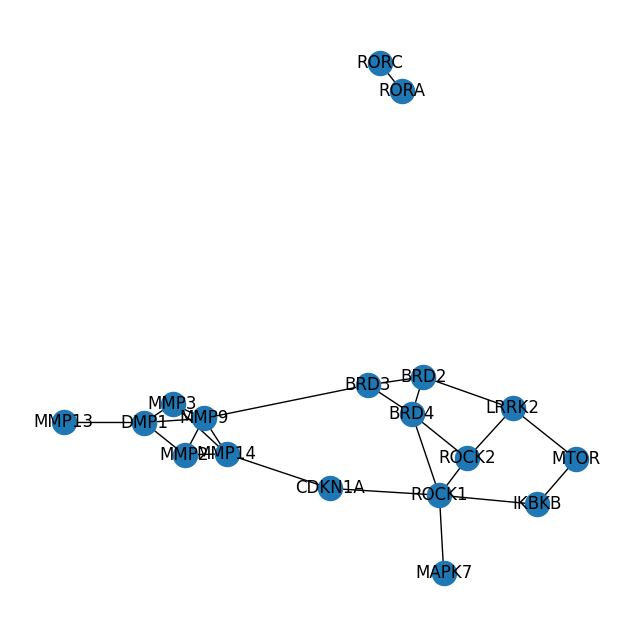

In [168]:
reload(c)
#Generate new network from string-db.

G_prel_clust, interactions_clust = tpp.retrievePreliminaryNetwork(cluster_targets_jq1, network_type="physical") 

/share/data/analyses/camilla/cp_tpp/code/cp_tpp_model/tpp/tpp.py:919: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pTPM_dict[i] = float(cluster_count_df[cluster_count_df["Target"] == i]["Count"]) #This gives warning now.


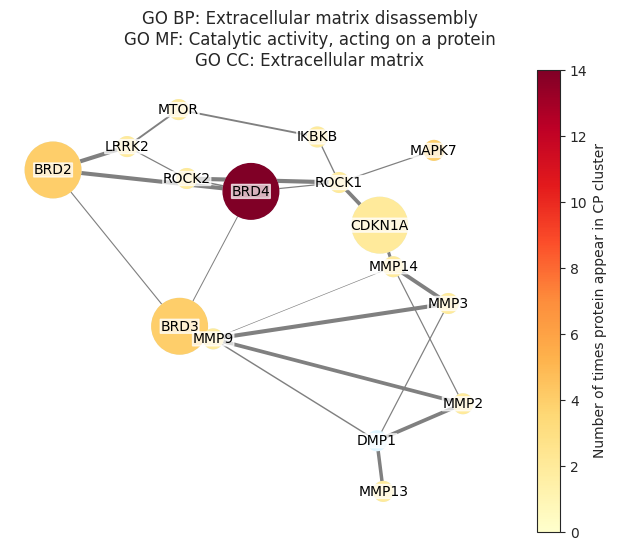

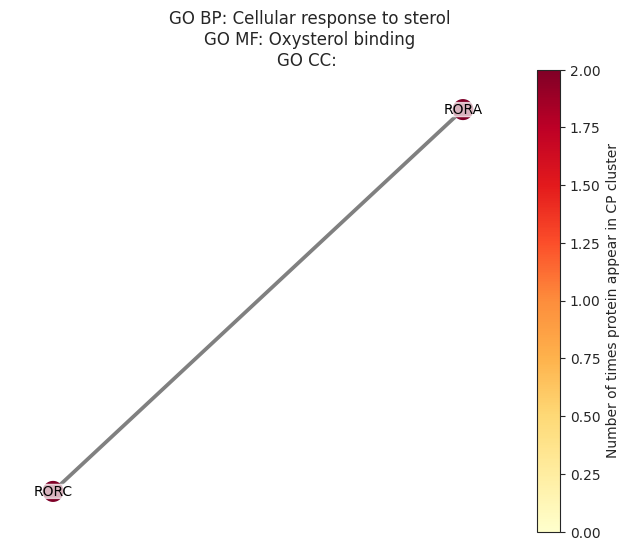

               0
ROCK1   0.336508
MMP9    0.287302
BRD3    0.266667
CDKN1A  0.190476
MMP14   0.188889
BRD4    0.147619
DMP1    0.136508
BRD2    0.117460
LRRK2   0.082540
IKBKB   0.050794


In [169]:
between_c_clust = tpp.plotPPINetwork(G_prel_clust, 
                             interactions_clust, 
                             community=2, #Number of separate (not connected) networks seen in preliminary network figure above.
                             protein_list=proteins_all_jq1,
                             external_data=external_data,
                             #file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/ppi_network_jq1_clusterCountonlyClusterProteins_v2.svg',
                             label_method="cluster count",
                             celline = "THP-1",
                             cluster_count_df = cluster_protein_counts,
                             figure_size=(8,6)
                )

between_clust_df = tpp.findLargestBetweennessCentrality(between_c_clust, proteins_all_jq1, removeList=False, output_size=10)
print(between_clust_df)

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin' will be ignored
  node_collection = ax.scatter(


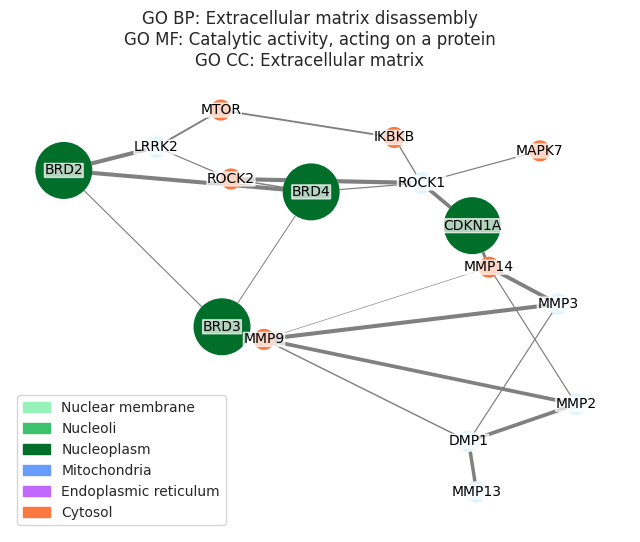

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin' will be ignored
  node_collection = ax.scatter(


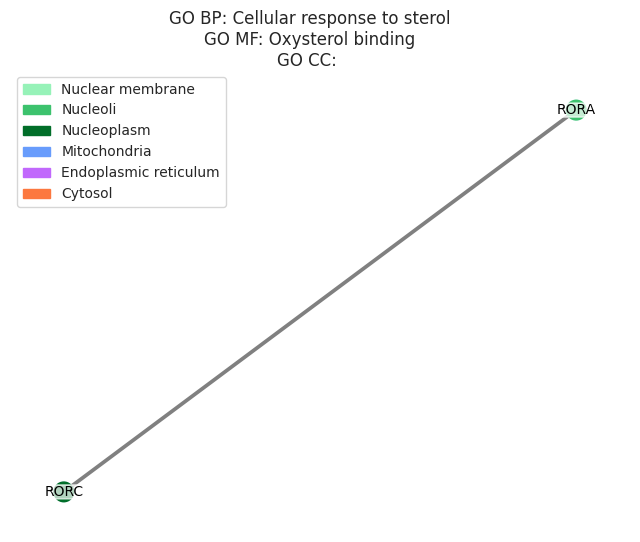

In [149]:
between_c_clust = tpp.plotPPINetwork(G_prel_clust, 
                             interactions_clust, 
                             community=2, #Number of separate (not connected) networks seen in preliminary network figure above.
                             protein_list=proteins_all_jq1,
                             external_data=external_data,
                             file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/ppi_network_jq1_clusterCountonlyClusterProteins_subcellular_v2.svg',
                             label_method="subcellular",
                             celline = "THP-1",
                             cluster_count_df = cluster_protein_counts,
                             figure_size=(8,6)
                )

### I-BET151
#### Plot networks

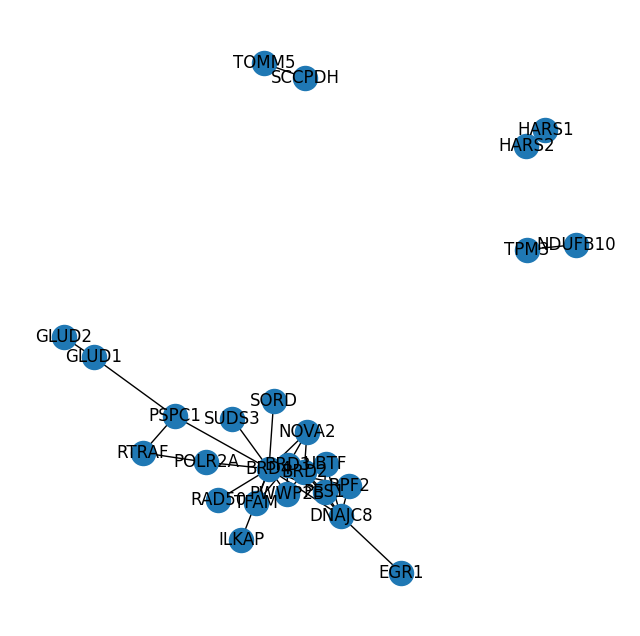

In [183]:
#Plot preliminary network
reload(c)
G_prel, interactions = tpp.retrievePreliminaryNetwork(proteins_all_ibet151, network_type="physical")

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin' will be ignored
  node_collection = ax.scatter(


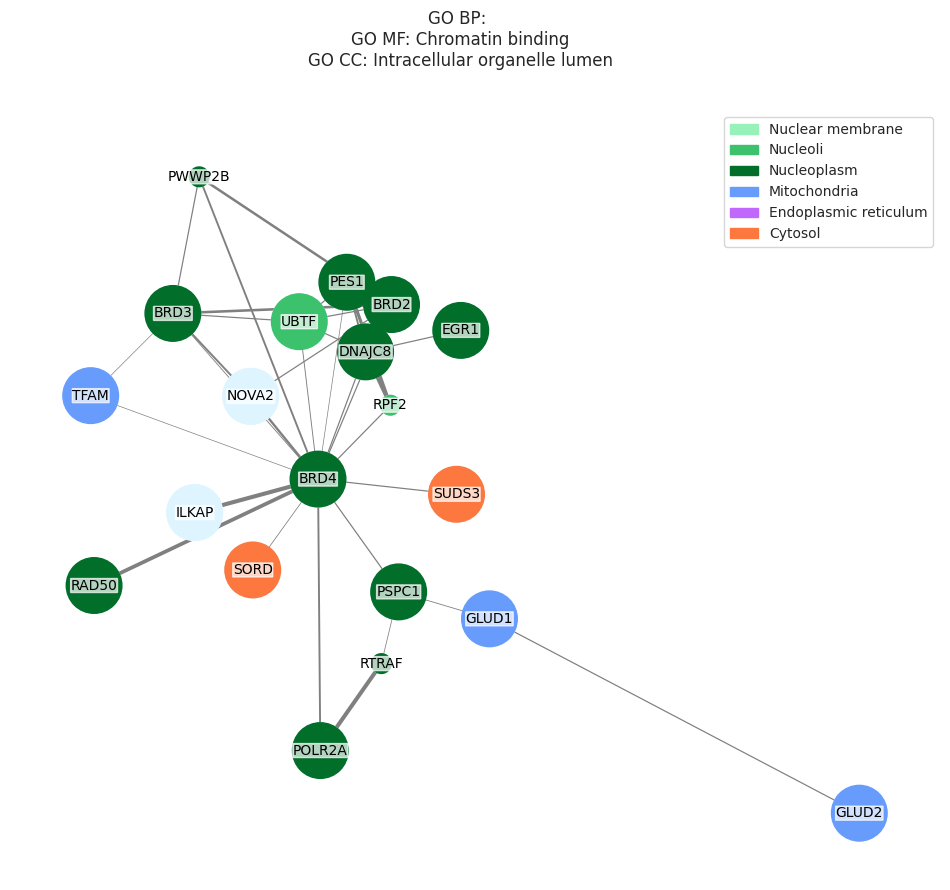

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin' will be ignored
  node_collection = ax.scatter(


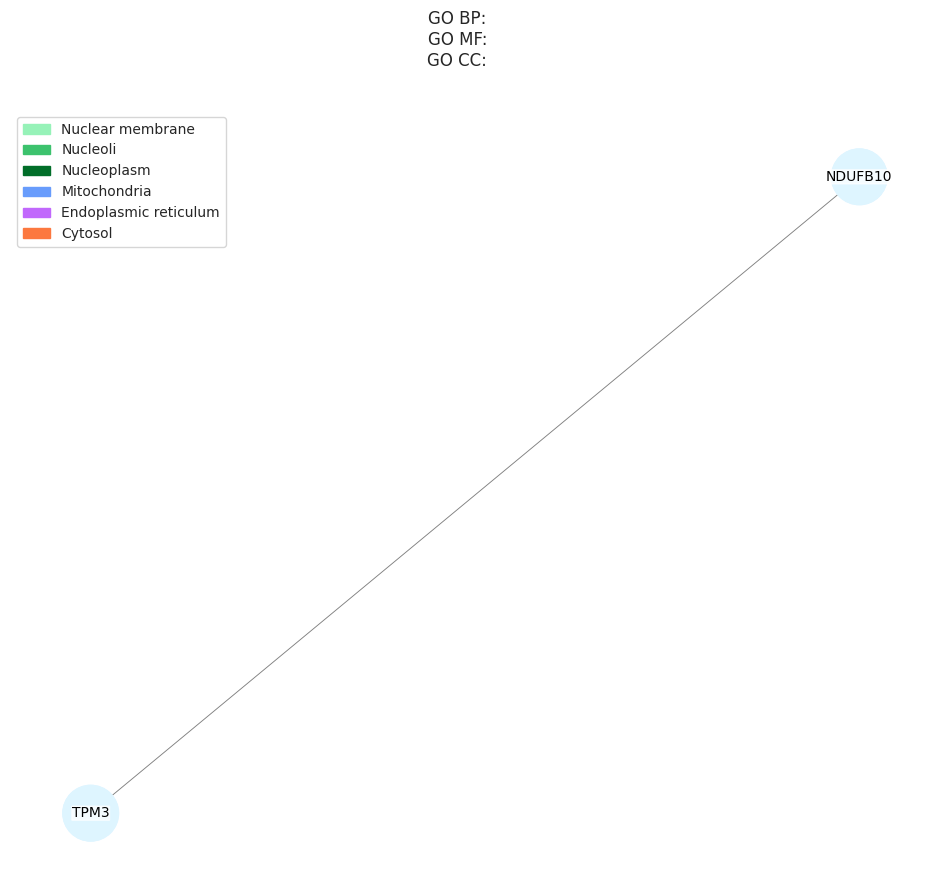

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin' will be ignored
  node_collection = ax.scatter(


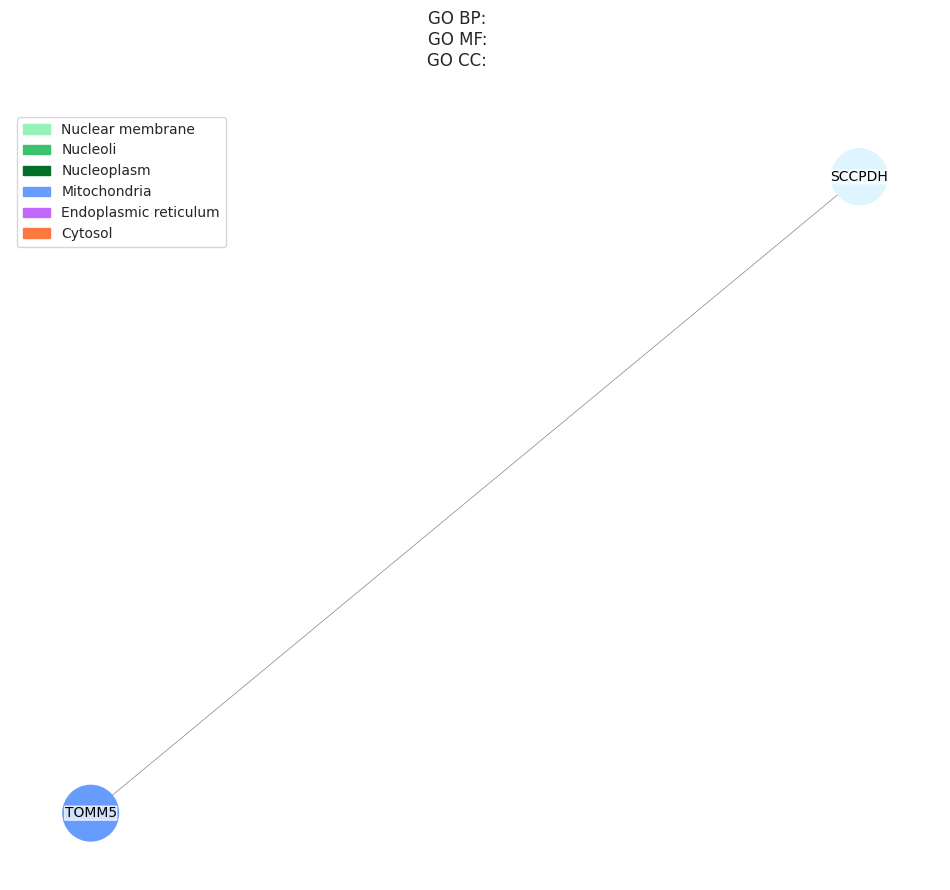

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin' will be ignored
  node_collection = ax.scatter(


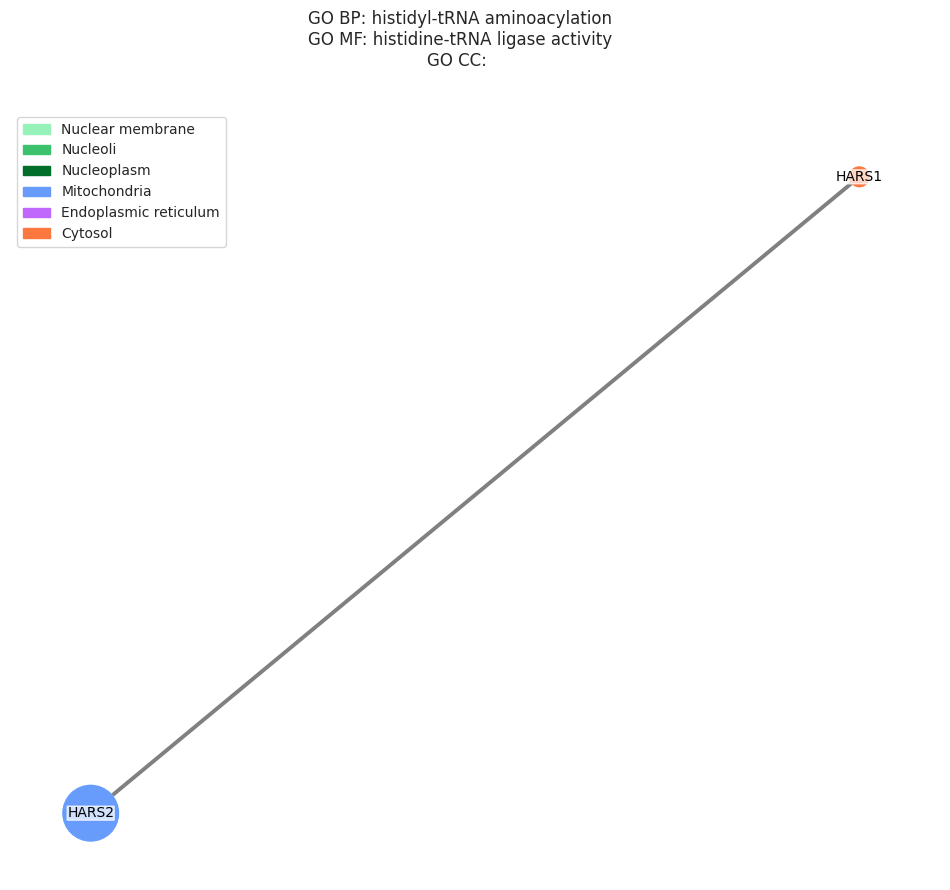

In [184]:
reload(tpp)
between_c = tpp.plotPPINetwork(G_prel, 
                             interactions, 
                             community=4, #Number of separate (not connected) networks seen in preliminary network figure above.
                             protein_list=proteins_all_ibet151,
                             external_data=external_data,
                             file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/ppi_network_ibet151_subcellular_wc_physical_v2.svg',
                             label_method="subcellular",
                             celline = "THP-1",
                             figure_size=(12,10)
                )

In [185]:
reload(c)
#Summarize betweenness centrality for network. 
between_df = tpp.findLargestBetweennessCentrality(between_c, proteins_all_ibet151, removeList=False, output_size=10)
print(between_df)

               0
BRD4    0.772904
PSPC1   0.242690
DNAJC8  0.109162
GLUD1   0.105263
POLR2A  0.043860
BRD2    0.029240
BRD3    0.017544
RTRAF   0.008772
UBTF    0.005848
PES1    0.003899


In [186]:
#Import proteins from cluster
compound = ['(+)-JQ1', 'I-BET151']
cluster_compound_ibet151 = clusters_compounds[compound[1]]

cluster_targets_ibet151 = tpp.findClusterProteins(dfGroupedByPlate1, annotations, cluster_highlight=cluster_compound_ibet151, compound=compound, CompoundNames=CompoundNames)

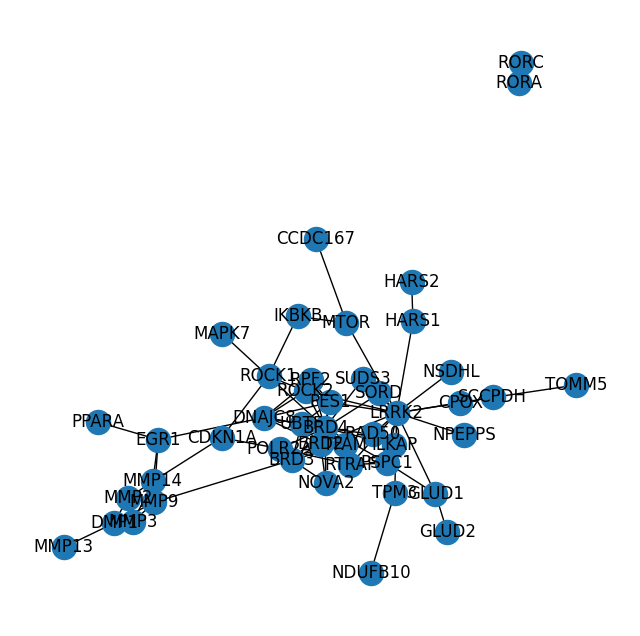

In [187]:
#Generate new network from string-db.
proteins_withCluster_ibet151 = list(set(proteins_all_ibet151+cluster_targets_ibet151))

G_prel_clust, interactions_clust = tpp.retrievePreliminaryNetwork(proteins_withCluster_ibet151, network_type="physical") 

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin' will be ignored
  node_collection = ax.scatter(


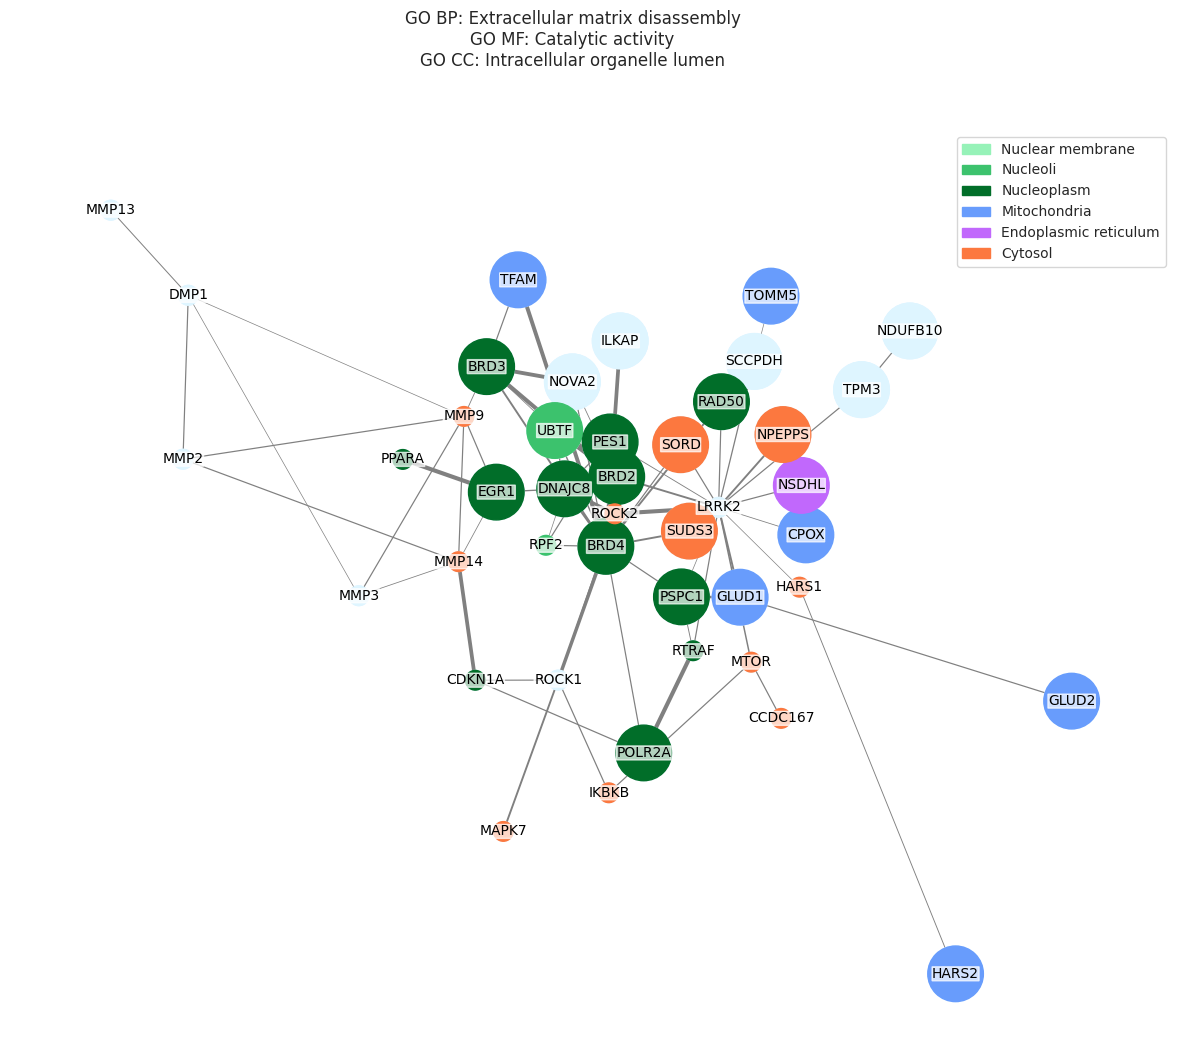

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin' will be ignored
  node_collection = ax.scatter(


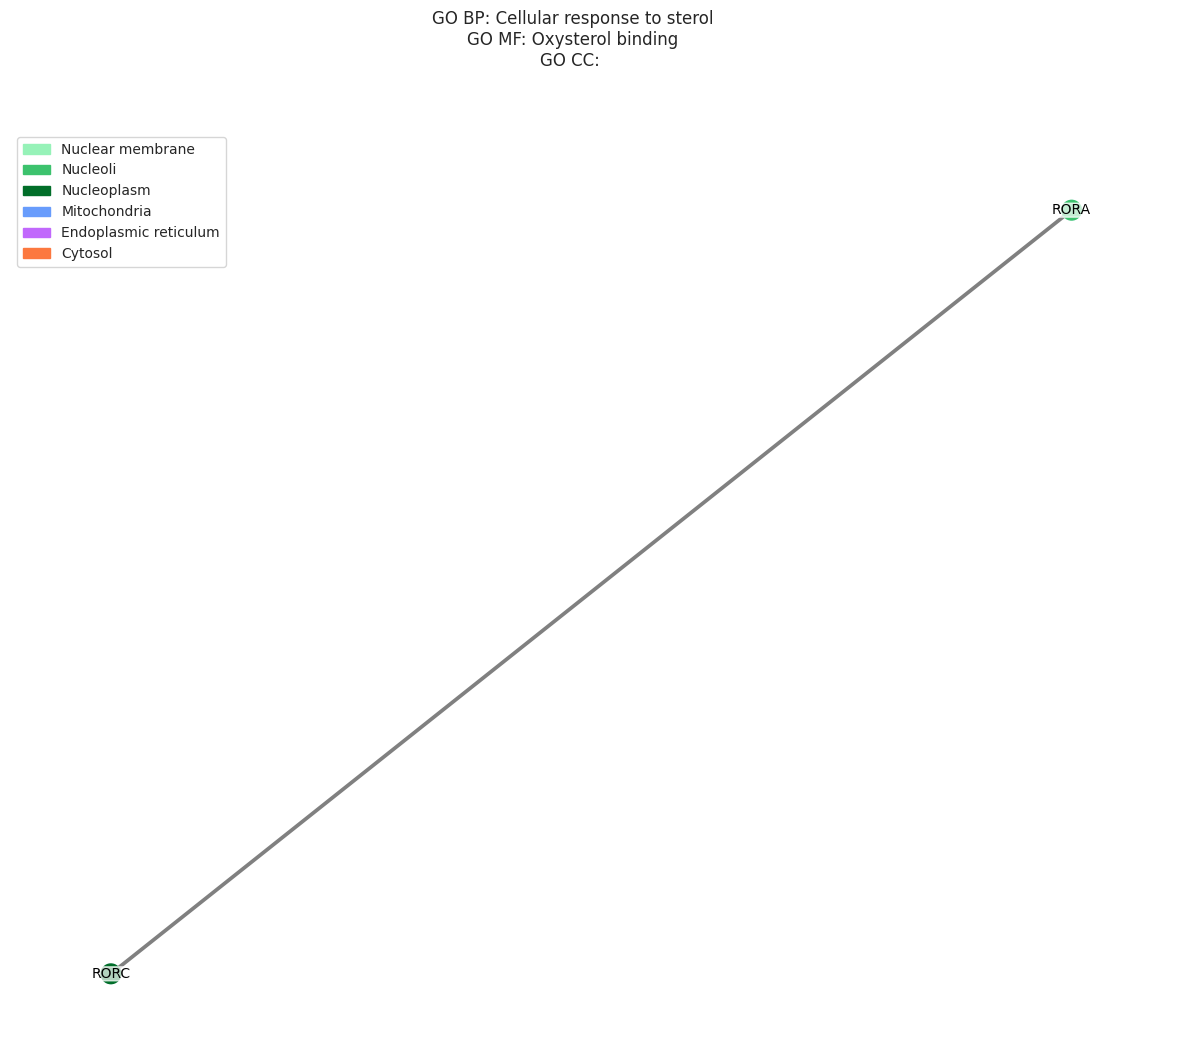

               0
LRRK2   0.506990
MMP9    0.157275
ROCK1   0.101823
MTOR    0.066202
ROCK2   0.062961
CDKN1A  0.048694
DMP1    0.048006
HARS1   0.047619


In [188]:
#Plot new network from string-db.
reload(c)
between_c_clust = tpp.plotPPINetwork(G_prel_clust, 
                             interactions_clust, 
                             community=2, #Number of separate (not connected) networks seen in preliminary network figure above.
                             protein_list=proteins_all_ibet151,
                             external_data=external_data,
                             #file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/ppi_network_jq1_subcellular.svg',
                             label_method="subcellular",
                             #celline = "THP-1",
                             figure_size=(15,12)
                )
#Calculate betweenness centrality and keep only 5 best "additional" nodes. 
between_clust_df = tpp.findClusterProteinsToKeepInNetwork(between_c_clust, proteins_all_ibet151, interactions_clust)
print(between_clust_df)

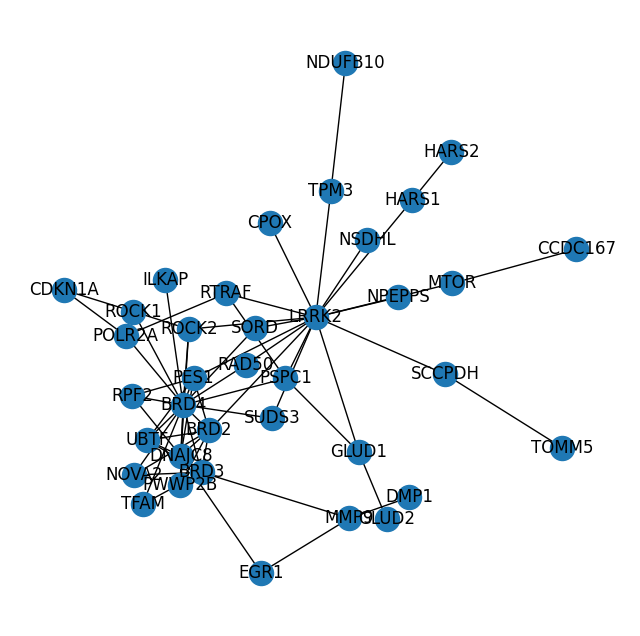

In [189]:
#Generate network with only best nodes
proteins_reducedCluster_ibet151 = list(set(proteins_all_ibet151+list(between_clust_df.index)))

G_prel_clust, interactions_clust = tpp.retrievePreliminaryNetwork(proteins_reducedCluster_ibet151, network_type="physical") 

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin' will be ignored
  node_collection = ax.scatter(


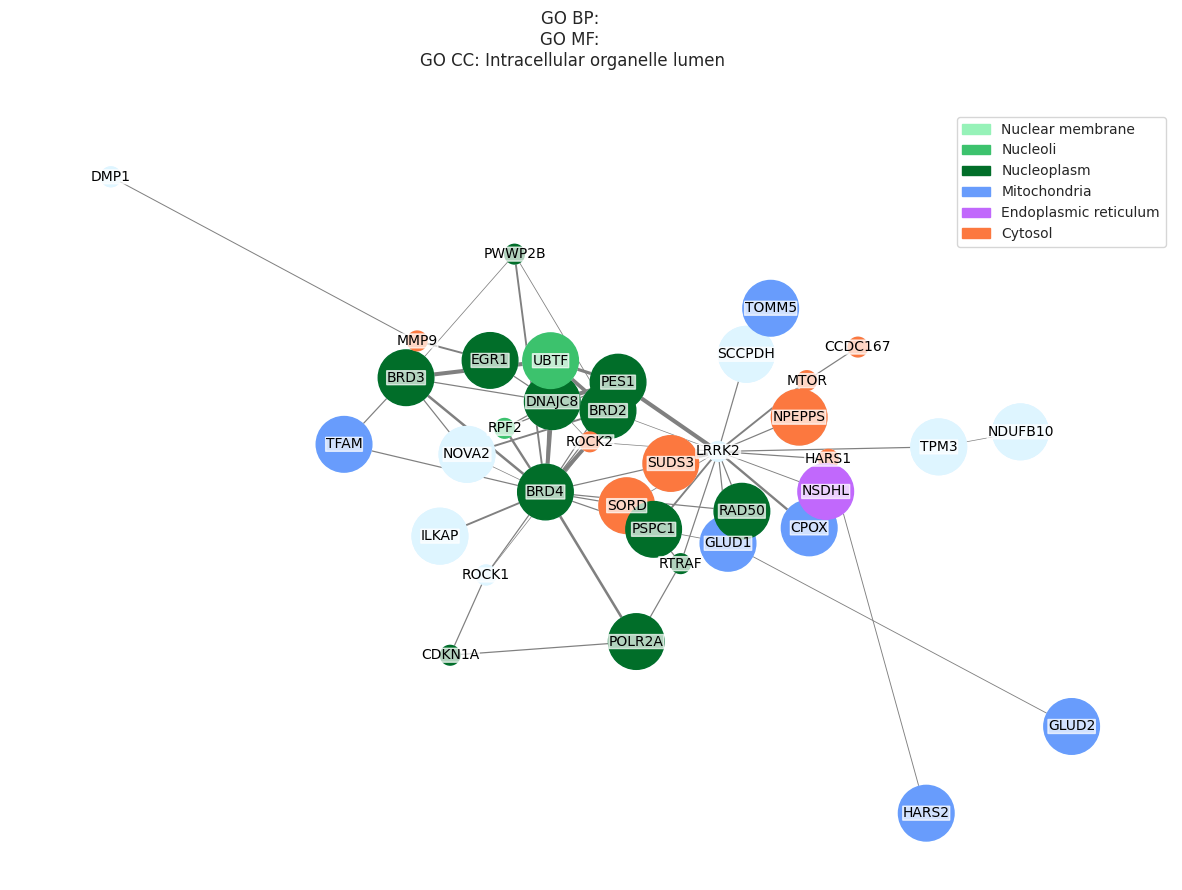

               0
LRRK2   0.589550
BRD4    0.289048
BRD2    0.149596
BRD3    0.106614
MMP9    0.058995
DNAJC8  0.056614
ROCK2   0.056580
PES1    0.055945
SCCPDH  0.055556
MTOR    0.055556


In [190]:
#Plot final network.
reload(tpp)
between_c_clust = tpp.plotPPINetwork(G_prel_clust, 
                             interactions_clust, 
                             community=1, #Number of separate (not connected) networks seen in preliminary network figure above.
                             protein_list=proteins_all_ibet151,
                             external_data=external_data,
                             file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/ppi_network_ibet151_subcellular_wc_physical_wCluster_v2.svg',
                             label_method="subcellular",
                             celline = "THP-1",
                             figure_size=(15,10)
                )
#Calculate betweenness centrality and keep only 5 best "additional" nodes. 
between_clust_df = tpp.findLargestBetweennessCentrality(between_c_clust, proteins_all_ibet151, removeList=False, output_size=10)
print(between_clust_df)

/share/data/analyses/camilla/cp_tpp/code/cp_tpp_model/tpp/tpp.py:921: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  


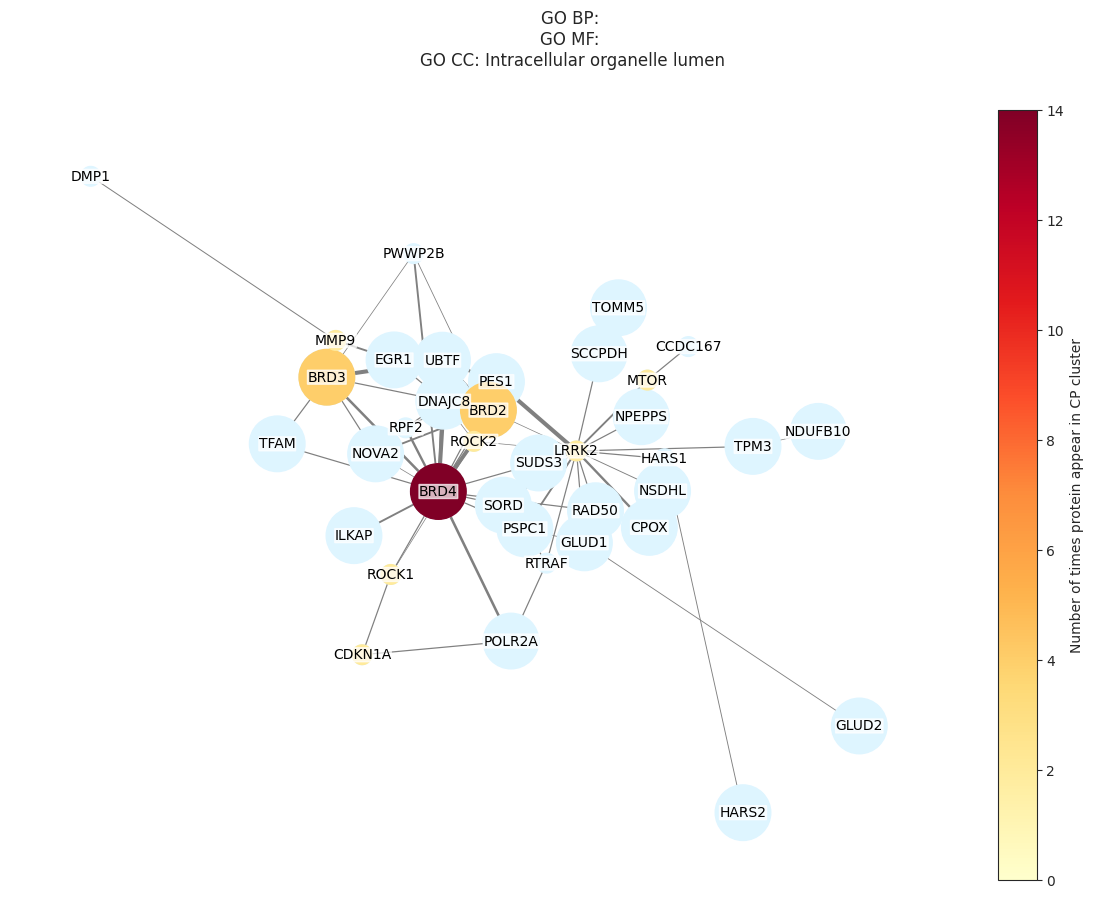

               0
LRRK2   0.589550
BRD4    0.289048
BRD2    0.149596
BRD3    0.106614
MMP9    0.058995
DNAJC8  0.056614
ROCK2   0.056580
PES1    0.055945
SCCPDH  0.055556
MTOR    0.055556


In [191]:
#Plot final network.
reload(tpp)
between_c_clust = tpp.plotPPINetwork(G_prel_clust, 
                             interactions_clust, 
                             community=1, #Number of separate (not connected) networks seen in preliminary network figure above.
                             protein_list=proteins_all_ibet151,
                             external_data=external_data,
                             #file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/ppi_network_ibet151_subcellular_wc_physical_wCluster_v2.svg',
                             label_method="cluster count",
                             celline = "THP-1",
                             cluster_count_df = cluster_protein_counts,
                             figure_size=(15,10)
                )
#Calculate betweenness centrality and keep only 5 best "additional" nodes. 
between_clust_df = tpp.findLargestBetweennessCentrality(between_c_clust, proteins_all_ibet151, removeList=False, output_size=10)
print(between_clust_df)

#### Communities and GO/Reactome enrichment

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin' will be ignored
  node_collection = ax.scatter(


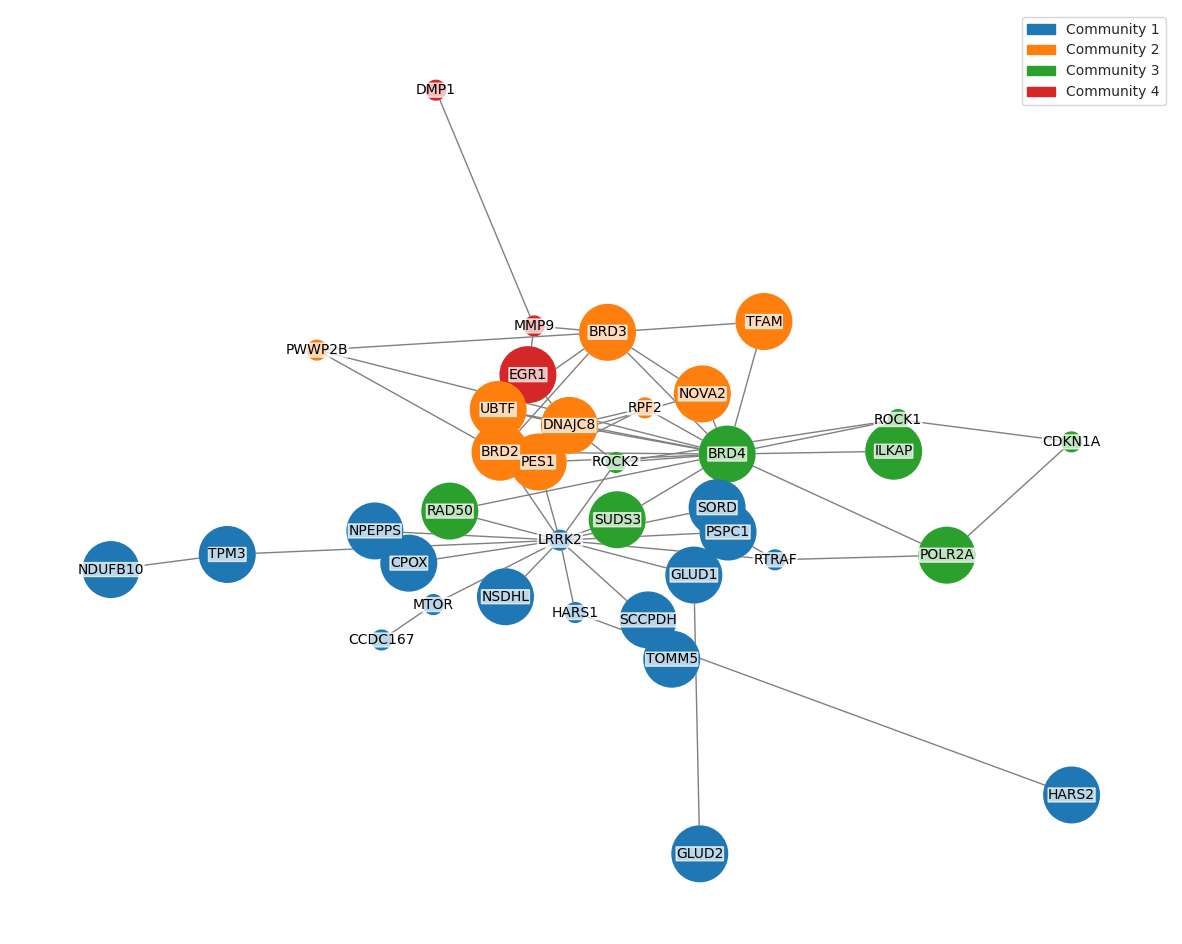

In [194]:
#Plot PPI network graph with communities as colors 
reload(tpp)
enrichment = tpp.plotPPINetworkCommunitites(G_prel_clust, 
                             interactions_clust, 
                             community=8, #Number of communities to subdivide graph into.
                             protein_list=proteins_all_ibet151,
                             method = 'greedy_modularity_communities', # Method for identifying communitites. 
                             file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/ppi_network_ibet151_communities_wc_physical_wCluster_2000rep.svg',
                             figure_size=(15,12)
                )

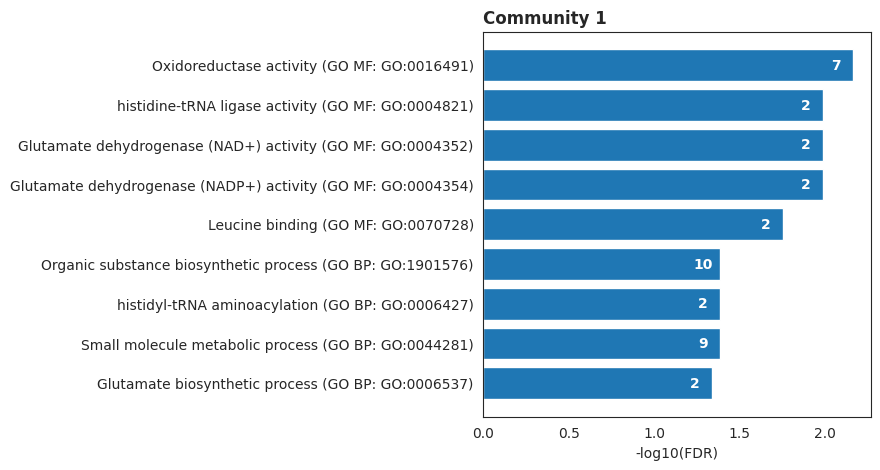

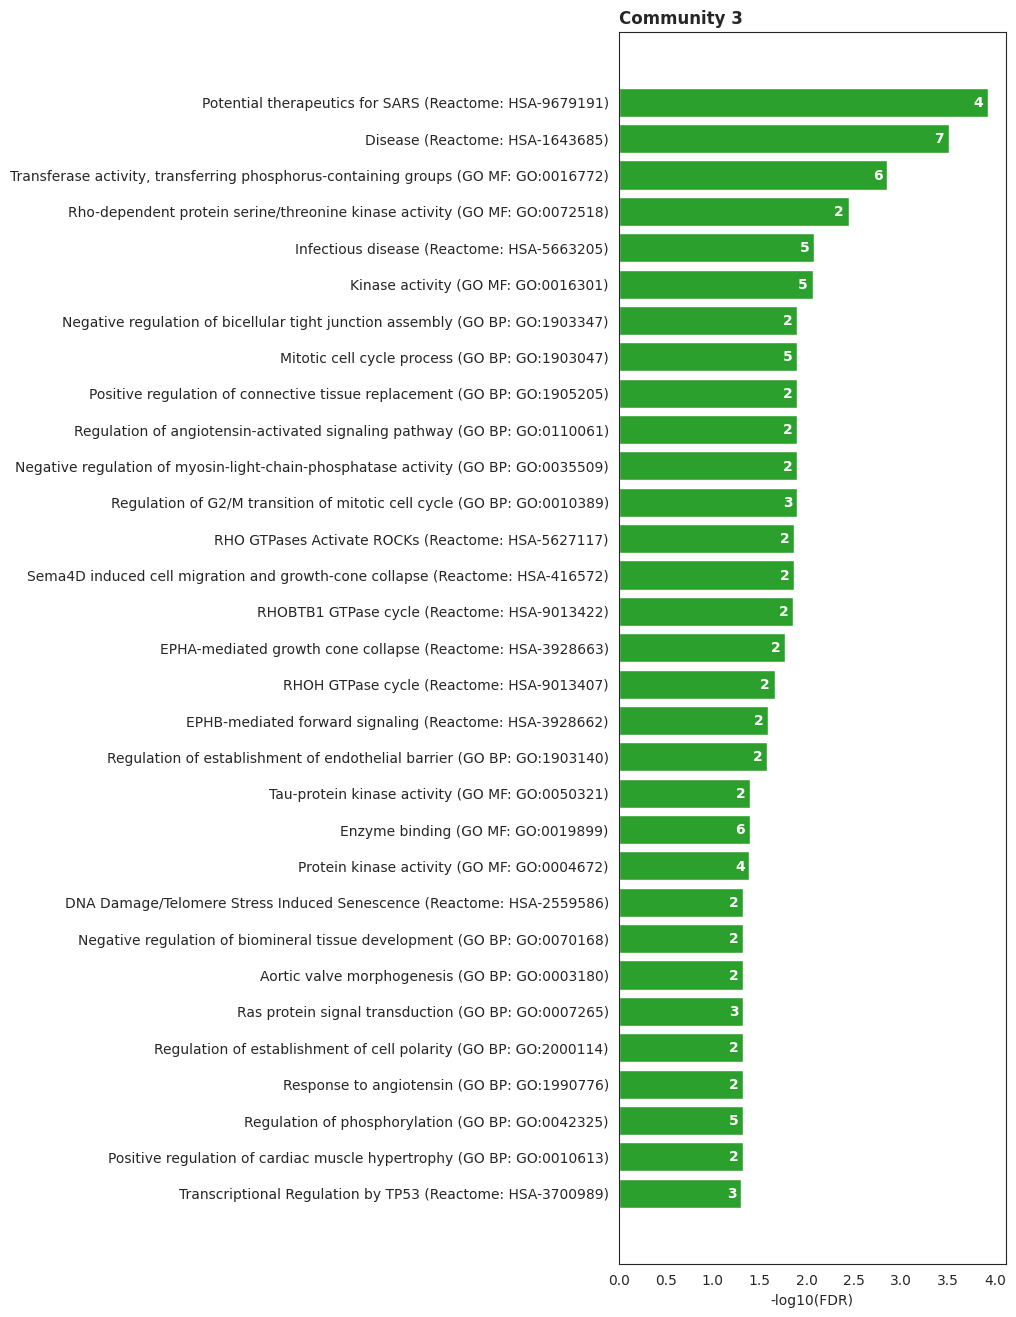

In [193]:
# Plots GO enrichment analysis for communitites. 
reload(tpp)
tpp.plotGOenrichmentCommunities(enrichment, 
                            file_name = "/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/enrichment_plots_ibet151_communities_wc_physical_wCluster_2000rep.svg"
                           )

#### Network on cluster compounds only

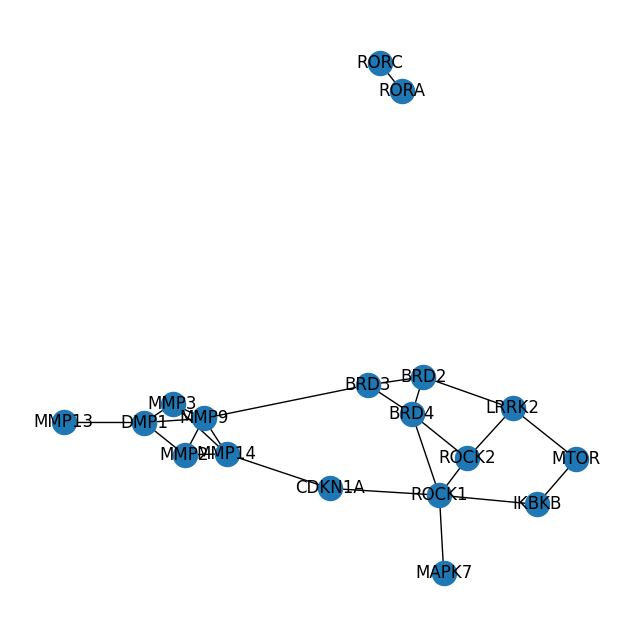

In [159]:
reload(c)
#Generate new network from string-db.

G_prel_clust, interactions_clust = tpp.retrievePreliminaryNetwork(cluster_targets_ibet151, network_type="physical") 

/share/data/analyses/camilla/cp_tpp/code/cp_tpp_model/tpp/tpp.py:919: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pTPM_dict[i] = float(cluster_count_df[cluster_count_df["Target"] == i]["Count"]) #This gives warning now.


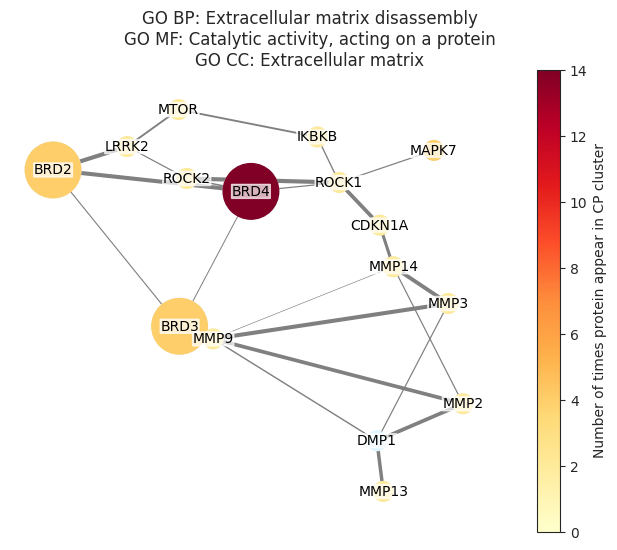

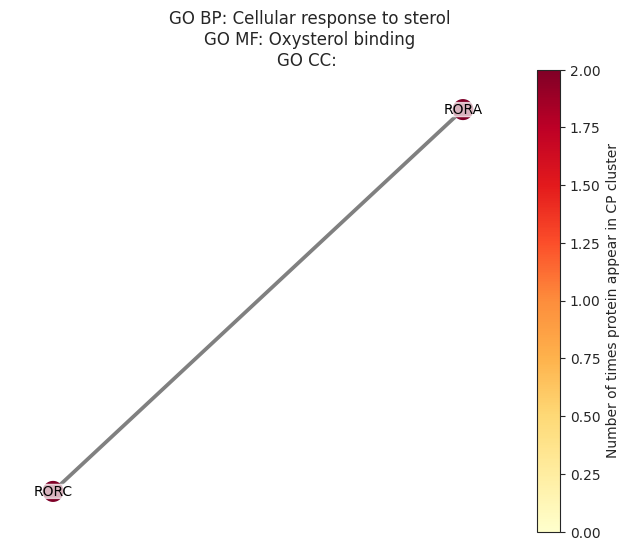

In [160]:
between_c_clust = tpp.plotPPINetwork(G_prel_clust, 
                             interactions_clust, 
                             community=2, #Number of separate (not connected) networks seen in preliminary network figure above.
                             protein_list=proteins_all_ibet151,
                             external_data=external_data,
                             file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/ppi_network_ibet151_clusterCountonlyClusterProteins_v2.svg',
                             label_method="cluster count",
                             celline = "THP-1",
                             cluster_count_df = cluster_protein_counts,
                             figure_size=(8,6)
                )

### Extract MoA information from CP cluster
The cluster in cell painting data can also be used to propose MoA. Here we extract and cound those detected MoAs (without including the MoA annotations from target compounds) and plot as histograms. 

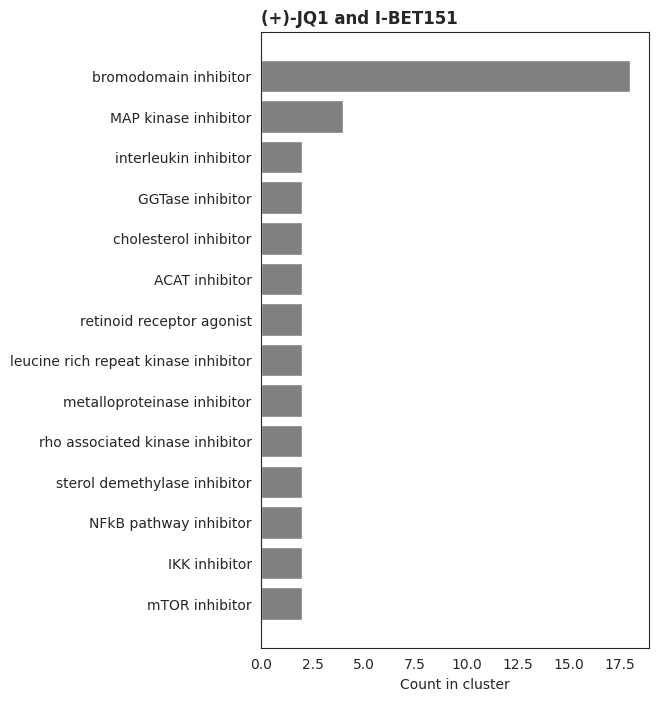

In [197]:
reload(tpp)
compound_list_cluster = tpp.plotClusterMOA(dfGroupedByPlate1, 
                   annotations, 
                   clusters_compounds['(+)-JQ1'], 
                   ['(+)-JQ1', 'I-BET151'], 
                   CompoundNames,
                   file_name = '/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/barchart_jq1_ibet151_cluster_moa_2000rep.svg'
                  )

In [199]:
#CBKID for unique compounds included in cluster
compound_list_cluster

['CBK308120',
 'CBK308725',
 'CBK309065',
 'CBK288346',
 'CBK308138',
 'CBK308848',
 'CBK293897',
 'CBK301248',
 'CBK308994',
 'CBK303883',
 'CBK308648',
 'CBK290504',
 'CBK308293',
 'CBK290227',
 'CBK303895',
 'CBK309552',
 'CBK308472',
 'CBK308106',
 'CBK308276',
 'CBK278077',
 'CBK308765']

### Venn diagrams

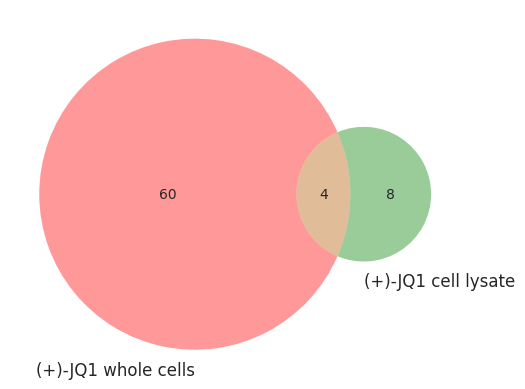

In [53]:
import matplotlib.pyplot as plt
#Plot Venn Diagram for intercept between whole cells and cell lysat fore JQ1
set1 = set(proteins_all_jq1)
set2 = set(proteins_all_jq1_ce)

venn2((set1, set2), set_labels = ('(+)-JQ1 whole cells', '(+)-JQ1 cell lysate'))

plt.savefig("/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/venn_diagram_jq1_wc_vs_ce.svg")
plt.show()

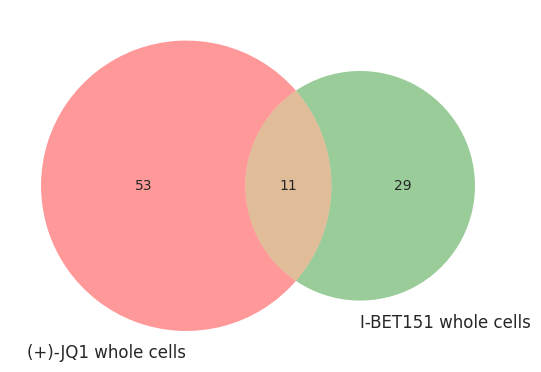

In [54]:
#Plot Venn Diagram for intercept between JQ1 and I-BET151 (whole cells)
set1 = set(proteins_all_jq1)
set2 = set(proteins_all_ibet151)

venn2((set1, set2), set_labels = ('(+)-JQ1 whole cells', 'I-BET151 whole cells'))

plt.savefig("/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/venn_diagram_jq1_vs_ibet151.svg")
plt.show()

### Identifying potentially missing hub nodes in network based on top 10 protein list. 
Retrieve all STRING interactions for top 10 protein list of the combined TPP-CP network. Count prevalence of interactions above a score

In [99]:
reload(tpp)
#df_newHubs = tpp.findAdditionalHubProteins(list(between_c_clust[0].keys()), network_type="physical")
df_newHubs = tpp.findAdditionalHubProteins(list(between_clust_df.index), proteins_all_jq1, network_type="physical")



In [100]:
df_newHubs.head()

interactor  count
758       TOP1      3
187       H4C6      3
628      SRSF9      2
707       MBD3      2
496       MLKL      2

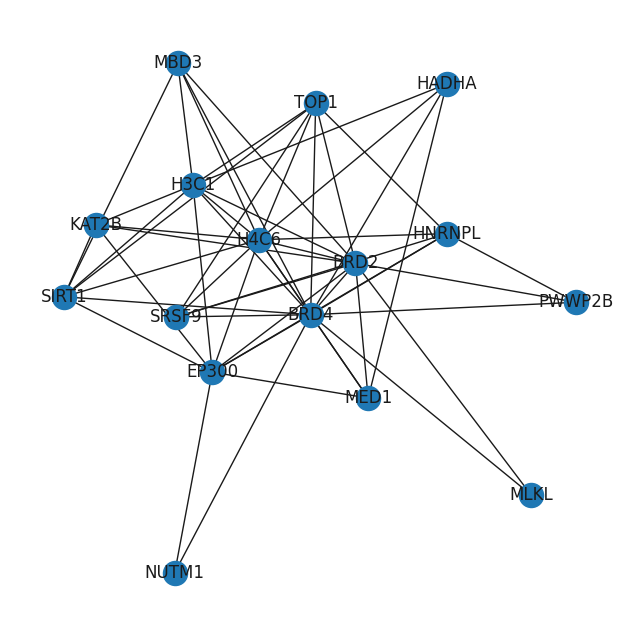

In [101]:
#New network with top 10 of these extra hubs added: 
proteins_hubs = list(df_newHubs.head(5)['interactor'])
proteins_withHubs_jq1 = list(set(proteins_hubs+list(between_clust_df.index)))

G_prel_hub, interactions_hub = tpp.retrievePreliminaryNetwork(proteins_withHubs_jq1, network_type="physical") 

/share/data/analyses/camilla/cp_tpp/code/cp_tpp_model/tpp/tpp.py:710: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pTPM_dict[i] = float(cluster_count_df[cluster_count_df["Target"] == i]["Count"]) #This gives warning now.


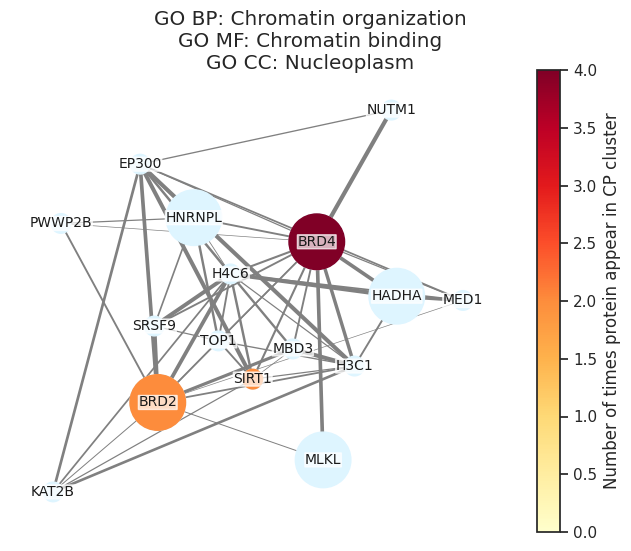

               0
BRD4    0.268980
BRD2    0.123492
H4C6    0.094694
EP300   0.063900
H3C1    0.032472
HNRNPL  0.016667
TOP1    0.013265
SIRT1   0.012063
MED1    0.004762
HADHA   0.001905


In [103]:
between_c_clust = tpp.plotPPINetwork(G_prel_hub, 
                             interactions_hub, 
                             community=1, #Number of separate (not connected) networks seen in preliminary network figure above.
                             protein_list=proteins_all_jq1,
                             external_data=external_data,
                             file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/ppi_network_jq1_clusterCount_wc_physical_wAddedHubs_small.svg',
                             label_method="cluster count",
                             celline = "THP-1",
                             cluster_count_df = cluster_protein_counts,
                             figure_size=(8,6)
                )

between_clust_df = tpp.findLargestBetweennessCentrality(between_c_clust, proteins_all_jq1, removeList=False, output_size=10)
print(between_clust_df)

## Compare gene expression for targets between CP adn TPP
This code generates comparisons between protein expression in TPP cell line and CP cell line. 

1. Barchart with RNA expression from proteinatlas for known targets (and off-targets).

In [6]:
reload(tpp)
#Plot cell lines as barcharts
targets_to_compare = ['BRD4',
                      'BRDT',
                      'BRD2',
                      'BRD3',
                      'HADHA'
                     ]
#Import external cell line expression data from Human Protein Atlas
expression_df = pd.read_csv("/share/data/analyses/camilla/cp_tpp/raw_data/rna_celline.tsv", sep="\t")

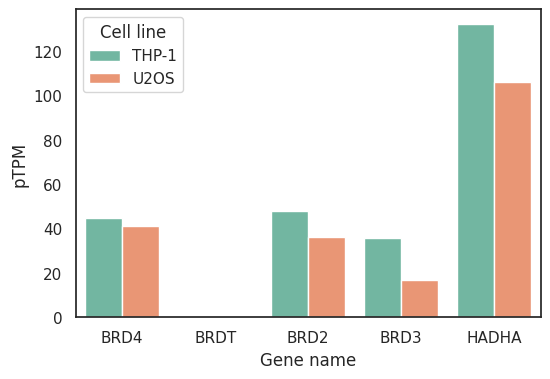

In [7]:
reload(tpp)
tpp.compareTargetRNAexpression_cellLines(expression_df, 
                                         targets = targets_to_compare, 
                                         cell_cp = 'U2OS', 
                                         cell_tpp = 'THP-1',
                                         figsize=(6,4),
                                         file_name = '/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/barchart_targetRNAexpression_cellline_jq1_ibet151.svg'
                                        )